In [100]:
import pandas as pd

In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
gold = pd.read_csv('/content/drive/MyDrive/DS_Project_files/gold_df.csv')

In [103]:
gold = gold[:10000]


In [104]:
gold.to_csv("sample_cricket.csv")

# Machine Learning Algorithm XGBClassifier (Parth Ravaliya)

In [105]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
%pip install XGBoost
%pip install shap
import joblib

import shap
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [106]:
# gold_df = pd.read_csv('gold_df.csv')
gold_df = pd.read_csv('/content/drive/MyDrive/DS_Project_files/gold_df.csv')



In [107]:

ml_parth = gold_df.copy()
ml_parth.shape
## Preparing dataset

(260430, 34)

In [108]:
ml_parth.columns

Index(['Unnamed: 0', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batter', 'bowler', 'non_striker', 'batsman_runs', 'extra_runs',
       'total_runs', 'extras_type', 'is_wicket', 'player_dismissed',
       'dismissal_kind', 'id', 'season', 'city', 'match_type',
       'player_of_match', 'venue', 'team1', 'team2', 'toss_winner',
       'toss_decision', 'winner', 'result', 'target_runs', 'target_overs',
       'super_over', 'umpire1', 'umpire2', 'year'],
      dtype='object')

In [109]:
match_spec_feature = ['season', 'city', 'match_type', 'venue', 'team1', 'team2',
    'toss_winner', 'toss_decision']
Team_Player_perf_features = ['inning', 'batting_team', 'bowling_team', 'over', 'ball', 'batter',
    'bowler', 'non_striker', 'batsman_runs', 'extra_runs', 'total_runs',
    'extras_type', 'is_wicket', 'player_dismissed', 'dismissal_kind']

In [110]:
features = match_spec_feature + Team_Player_perf_features

target = 'winner'

cols = [
    'inning', 'batting_team', 'bowling_team', 'over', 'ball', 'batter',
    'bowler', 'non_striker', 'batsman_runs', 'extra_runs', 'total_runs',
    'extras_type', 'is_wicket', 'player_dismissed', 'dismissal_kind',
    'season', 'city', 'match_type', 'venue', 'team1', 'team2',
    'toss_winner', 'toss_decision', 'umpire1', 'umpire2', 'year','winner'

]

In [111]:
df = ml_parth[cols]

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260430 entries, 0 to 260429
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   inning            260430 non-null  int64 
 1   batting_team      260430 non-null  object
 2   bowling_team      260430 non-null  object
 3   over              260430 non-null  int64 
 4   ball              260430 non-null  int64 
 5   batter            260430 non-null  object
 6   bowler            260430 non-null  object
 7   non_striker       260430 non-null  object
 8   batsman_runs      260430 non-null  int64 
 9   extra_runs        260430 non-null  int64 
 10  total_runs        260430 non-null  int64 
 11  extras_type       260430 non-null  object
 12  is_wicket         260430 non-null  int64 
 13  player_dismissed  260430 non-null  object
 14  dismissal_kind    260430 non-null  object
 15  season            260430 non-null  int64 
 16  city              260430 non-null  obj

## Approach : instances prediction with Team and player performance columns as feature

In [113]:
df = df[Team_Player_perf_features + [target]]

# Select features (X) and target (y)
X = df.drop('winner', axis=1)
y = df['winner']

print(f"\nShape of features (X): {X.shape}")
print(f"Shape of target (y): {y.shape}")
print("-" * 30)

# Initialize LabelEncoder for the target column first, to get classes for inverse transformation later
target_label_encoder = LabelEncoder()
y_encoded = target_label_encoder.fit_transform(y)

# Encode categorical features in X
for column in X.columns:
    if X[column].dtype == 'object':
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column])
        print(f"Encoded categorical feature: '{column}'")


print("\nX (features) after encoding categorical columns:")
print(X.head())
print("\ny (target) after encoding 'winner' column:")
print(pd.Series(y_encoded).head()) # Convert numpy array back to Series for display
print("-" * 30)

# Split the data into training and testing sets
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize the XGBClassifier with simple parameters
# Using default parameters for simplicity as requested, but setting `eval_metric` for silent output
# `use_label_encoder` is deprecated and implicitly False in newer XGBoost versions
model = XGBClassifier(eval_metric='mlogloss', random_state=42)

# Train the model
model.fit(X_train, y_train_encoded)

# Make predictions on the test set
y_pred_encoded = model.predict(X_test)

# Convert encoded predictions and true values back to original team names for better readability
y_test_original = target_label_encoder.inverse_transform(y_test_encoded)
y_pred_original = target_label_encoder.inverse_transform(y_pred_encoded)

print("\n--- Model Evaluation ---")

# Evaluate the model
accuracy = accuracy_score(y_test_original, y_pred_original)
report = classification_report(y_test_original, y_pred_original, zero_division=0) # zero_division=0 to handle cases with no true samples for a class

print(f"\nAccuracy Score: {accuracy:.4f}")
print("\nClassification Report:\n", report)

# Print y_test and y_pred (original team names for clarity)
print("\n--- y_test vs y_pred (First 20 samples) ---")
# Create a DataFrame for easy comparison
comparison_df = pd.DataFrame({
    'Actual Winner': y_test_original,
    'Predicted Winner': y_pred_original
})
print(comparison_df.head(20)) # Print first 20 for brevity

# Extensive Prediction Error Analysis
print("\n--- Prediction Error Analysis ---")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_original, y_pred_original)
# Get class labels in the order they appear in the confusion matrix
class_labels = target_label_encoder.classes_
print("\nConfusion Matrix:")
print(pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels))

# Identify misclassified examples (up to 10 for demonstration)
misclassified_indices = np.where(y_test_original != y_pred_original)[0]
print(f"\nTotal misclassified samples: {len(misclassified_indices)}")

if len(misclassified_indices) > 0:
    print("\nSome Misclassified Examples (Actual vs. Predicted):")
    # Take a sample of misclassified indices if there are too many
    sample_misclassified_indices = misclassified_indices[:min(len(misclassified_indices), 10)]

    for i in sample_misclassified_indices:
        actual_winner = y_test_original[i]
        predicted_winner = y_pred_original[i]
        # You might want to print some features of the misclassified sample here
        # E.g., X_test.iloc[i]
        print(f"Sample {i+1}: Actual='{actual_winner}', Predicted='{predicted_winner}'")
else:
    print("\nNo misclassified samples found in the test set. (This is rare with real data)")

print("\n--- End of Error Analysis ---")


Shape of features (X): (260430, 15)
Shape of target (y): (260430,)
------------------------------
Encoded categorical feature: 'batting_team'
Encoded categorical feature: 'bowling_team'
Encoded categorical feature: 'batter'
Encoded categorical feature: 'bowler'
Encoded categorical feature: 'non_striker'
Encoded categorical feature: 'extras_type'
Encoded categorical feature: 'player_dismissed'
Encoded categorical feature: 'dismissal_kind'

X (features) after encoding categorical columns:
   inning  batting_team  bowling_team  over  ball  batter  bowler  \
0       1             6             0     0     1     537     335   
1       1             6             0     0     2     102     335   
2       1             6             0     0     3     102     335   
3       1             6             0     0     4     102     335   
4       1             6             0     0     5     102     335   

   non_striker  batsman_runs  extra_runs  total_runs  extras_type  is_wicket  \
0          1

In [114]:
df = df[Team_Player_perf_features + [target]]

# Select features (X) and target (y)
X = df.drop('winner', axis=1)
y = df['winner']

print(f"\nShape of features (X): {X.shape}")
print(f"Shape of target (y): {y.shape}")
print("-" * 30)

# Initialize LabelEncoder for the target column first, to get classes for inverse transformation later
target_label_encoder = LabelEncoder()
y_encoded = target_label_encoder.fit_transform(y)

# Encode categorical features in X
for column in X.columns:
    if X[column].dtype == 'object':
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column])
        print(f"Encoded categorical feature: '{column}'")


print("\nX (features) after encoding categorical columns:")
print(X.head())
print("\ny (target) after encoding 'winner' column:")
print(pd.Series(y_encoded).head()) # Convert numpy array back to Series for display
print("-" * 30)

# Split the data into training and testing sets
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize the XGBClassifier with simple parameters
# Using default parameters for simplicity as requested, but setting `eval_metric` for silent output
# `use_label_encoder` is deprecated and implicitly False in newer XGBoost versions
model = XGBClassifier(eval_metric='mlogloss', random_state=42)

# Train the model
model.fit(X_train, y_train_encoded)

# Make predictions on the test set
y_pred_encoded = model.predict(X_test)

# Convert encoded predictions and true values back to original team names for better readability
y_test_original = target_label_encoder.inverse_transform(y_test_encoded)
y_pred_original = target_label_encoder.inverse_transform(y_pred_encoded)

print("\n--- Model Evaluation ---")

# Evaluate the model
accuracy = accuracy_score(y_test_original, y_pred_original)
report = classification_report(y_test_original, y_pred_original, zero_division=0) # zero_division=0 to handle cases with no true samples for a class

print(f"\nAccuracy Score: {accuracy:.4f}")
print("\nClassification Report:\n", report)




Shape of features (X): (260430, 15)
Shape of target (y): (260430,)
------------------------------
Encoded categorical feature: 'batting_team'
Encoded categorical feature: 'bowling_team'
Encoded categorical feature: 'batter'
Encoded categorical feature: 'bowler'
Encoded categorical feature: 'non_striker'
Encoded categorical feature: 'extras_type'
Encoded categorical feature: 'player_dismissed'
Encoded categorical feature: 'dismissal_kind'

X (features) after encoding categorical columns:
   inning  batting_team  bowling_team  over  ball  batter  bowler  \
0       1             6             0     0     1     537     335   
1       1             6             0     0     2     102     335   
2       1             6             0     0     3     102     335   
3       1             6             0     0     4     102     335   
4       1             6             0     0     5     102     335   

   non_striker  batsman_runs  extra_runs  total_runs  extras_type  is_wicket  \
0          1

In [115]:
y_test_original

array(['Mumbai', 'Rajasthan', 'Chennai', ..., 'Kolkata', 'Delhi',
       'Gujarat'], dtype=object)


--- y_test vs y_pred ---
      Actual Winner Predicted Winner  Correct Prediction
0            Mumbai           Mumbai                   1
1         Rajasthan        Rajasthan                   1
2           Chennai          Chennai                   1
3            Mumbai           Mumbai                   1
4              Pune             Pune                   1
...             ...              ...                 ...
52081       Chennai          Chennai                   1
52082     Bangalore        Bangalore                   1
52083       Kolkata           Mumbai                   0
52084         Delhi            Delhi                   1
52085       Gujarat          Gujarat                   1

[52086 rows x 3 columns]


/tmp/ipython-input-116-3456299731.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Correct Prediction', data=comparison_df, palette='viridis')


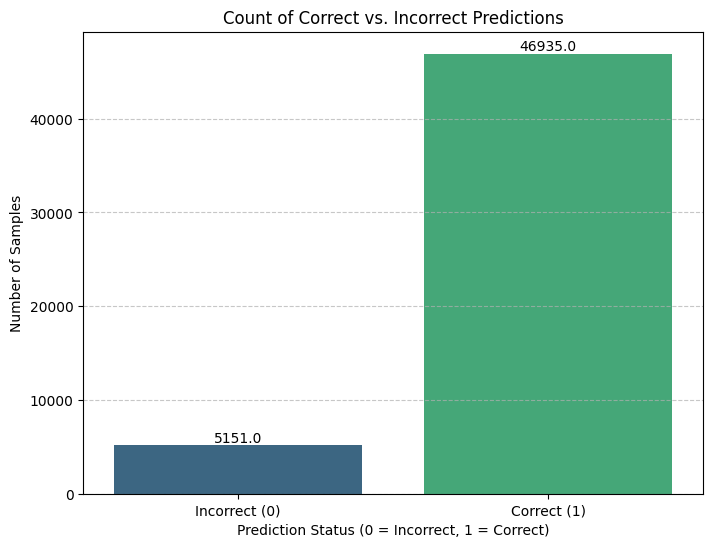

In [116]:
# Print y_test and y_pred (original team names for clarity)
print("\n--- y_test vs y_pred ---")
# Create a DataFrame for easy comparison
comparison_df = pd.DataFrame({
    'Actual Winner': y_test_original,
    'Predicted Winner': y_pred_original
})
# Add a column indicating if the prediction was correct
comparison_df['Correct Prediction'] = (comparison_df['Actual Winner'] == comparison_df['Predicted Winner']).astype(int)
print(comparison_df) # Print entire DataFrame

# Plotting the histogram of correct vs. incorrect predictions
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Correct Prediction', data=comparison_df, palette='viridis')
plt.title('Count of Correct vs. Incorrect Predictions')
plt.xlabel('Prediction Status (0 = Incorrect, 1 = Correct)')
plt.ylabel('Number of Samples')
plt.xticks(ticks=[0, 1], labels=['Incorrect (0)', 'Correct (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()


--- Feature Importance ---


/tmp/ipython-input-117-1191148561.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=features_df.values, y=features_df.index, palette='viridis')



Feature Importances (Top 15):
batting_team        0.478683
bowling_team        0.348434
inning              0.036163
non_striker         0.024869
batter              0.024312
bowler              0.019814
is_wicket           0.018372
total_runs          0.012747
over                0.012608
batsman_runs        0.009547
player_dismissed    0.003715
dismissal_kind      0.003177
extra_runs          0.002924
ball                0.002362
extras_type         0.002272
dtype: float32


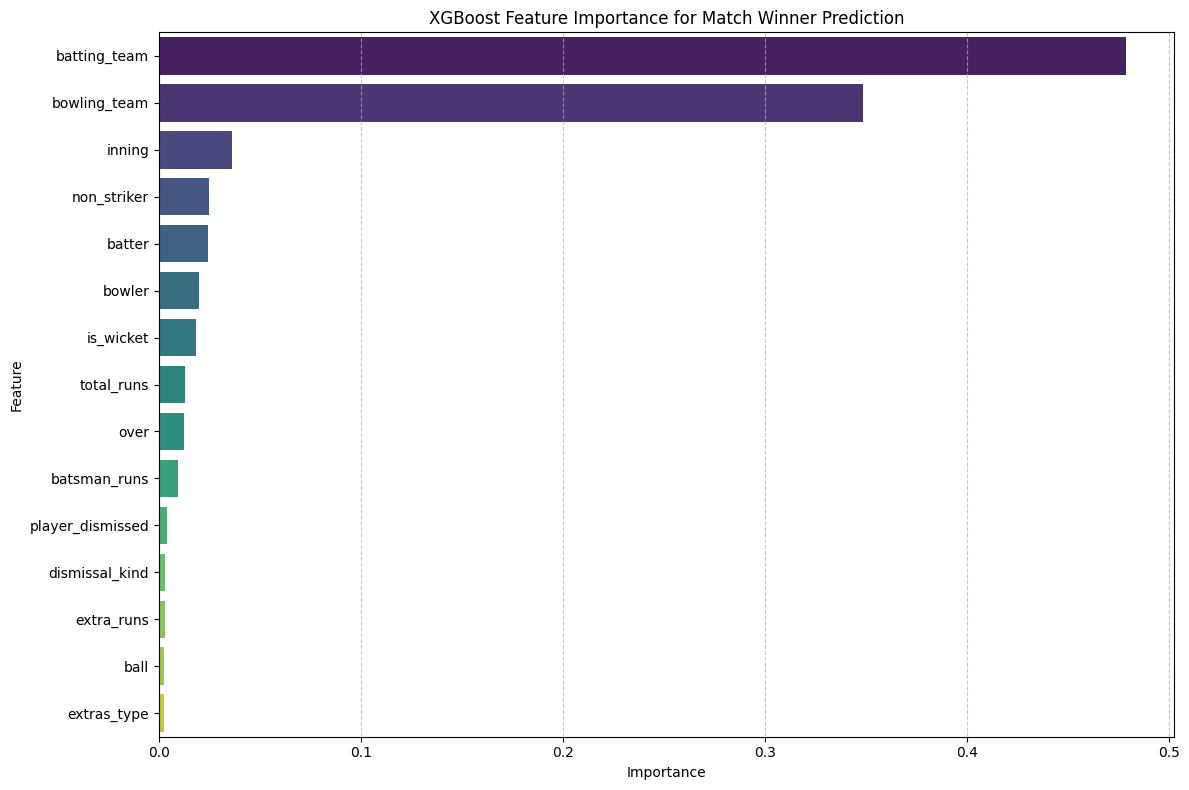

In [117]:
# Feature Importance
print("\n--- Feature Importance ---")
# Get feature importances from the trained model
feature_importances = model.feature_importances_

# Create a Series with feature names and their importances
features_df = pd.Series(feature_importances, index=X.columns)

# Sort the features by importance in descending order
features_df = features_df.sort_values(ascending=False)

print("\nFeature Importances (Top 15):")
print(features_df.head(15))

# Plotting feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=features_df.values, y=features_df.index, palette='viridis')
plt.title('XGBoost Feature Importance for Match Winner Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()



--- Prediction Error Analysis ---

Confusion Matrix:


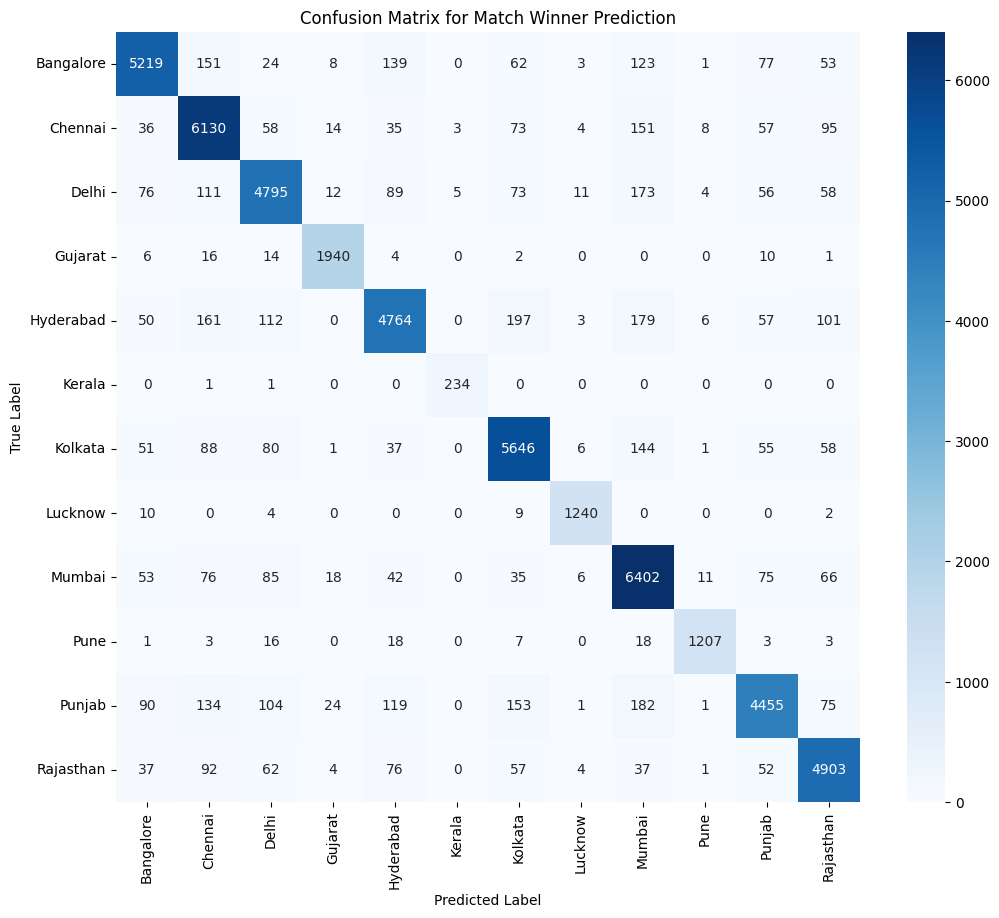


Total misclassified samples: 5151

Some Misclassified Examples (Actual vs. Predicted):
Sample 16: Actual='Hyderabad', Predicted='Delhi'
Sample 44: Actual='Rajasthan', Predicted='Hyderabad'
Sample 51: Actual='Punjab', Predicted='Mumbai'
Sample 67: Actual='Mumbai', Predicted='Hyderabad'
Sample 74: Actual='Delhi', Predicted='Hyderabad'
Sample 75: Actual='Punjab', Predicted='Rajasthan'
Sample 78: Actual='Delhi', Predicted='Hyderabad'
Sample 86: Actual='Kolkata', Predicted='Bangalore'
Sample 95: Actual='Punjab', Predicted='Hyderabad'
Sample 98: Actual='Punjab', Predicted='Mumbai'

--- End of Error Analysis ---


In [118]:
# Extensive Prediction Error Analysis
print("\n--- Prediction Error Analysis ---")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_original, y_pred_original)
# Get class labels in the order they appear in the confusion matrix
class_labels = target_label_encoder.classes_
print("\nConfusion Matrix:")
# Plotting the confusion matrix for better interpretability
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Match Winner Prediction')
plt.show()

# Identify misclassified examples (up to 10 for demonstration)
misclassified_indices = np.where(y_test_original != y_pred_original)[0]
print(f"\nTotal misclassified samples: {len(misclassified_indices)}")

if len(misclassified_indices) > 0:
    print("\nSome Misclassified Examples (Actual vs. Predicted):")
    # Take a sample of misclassified indices if there are too many
    sample_misclassified_indices = misclassified_indices[:min(len(misclassified_indices), 10)]

    for i in sample_misclassified_indices:
        actual_winner = y_test_original[i]
        predicted_winner = y_pred_original[i]
        # You might want to print some features of the misclassified sample here
        # E.g., X_test.iloc[i]
        print(f"Sample {i+1}: Actual='{actual_winner}', Predicted='{predicted_winner}'")
else:
    print("\nNo misclassified samples found in the test set. (This is rare with real data)")

print("\n--- End of Error Analysis ---")

You've raised a very important and insightful point! You are absolutely correct that predicting the winner using ball-by-ball data (as we are currently doing with sample_cricket.csv) will likely lead to an artificially inflated accuracy.

Here's why: When the model sees individual ball records, and the winner column is constant for all balls within a given match, the model essentially learns the outcome of that match many times over. It's not truly predicting the match winner based on pre-match or aggregated conditions, but rather, it's learning the winner given a specific ball's context within an already determined match. This causes the accuracy to look very high (often over 90%) because it's effectively "seeing the answer" repeatedly.

## Final approach : Aggregating innings score

In [119]:

### 1. Aggregate by innings
def aggregate_by_innings(df):
  """
    Aggregates the cricket dataset by innings for each match.

    Args:
        df (pd.DataFrame): The dataframe containing match and delivery data.

    Returns:
        pd.DataFrame: A dataframe with aggregated statistics for each match,
                      separated by inning.
    """
  inning1_df = df[df['inning'] == 1].groupby('id').agg(
      inning1_runs=('total_runs', 'sum'),
      inning1_wickets=('is_wicket', 'sum'),
      inning1_balls=('ball', 'count')
  ).reset_index()

  inning2_df = df[df['inning'] == 2].groupby('id').agg(
      inning2_runs=('total_runs', 'sum'),
      inning2_wickets=('is_wicket', 'sum'),
      inning2_balls=('ball', 'count')
  ).reset_index()

  # Merge the innings data
  aggregated_df = pd.merge(
      inning1_df,
      inning2_df,
      on='id',
      how='left'
  )

  # Handle matches that might have ended in the first inning (rare in T20, but possible)
  aggregated_df.fillna(0, inplace=True)

  # Add match-level information (assuming matches_df is available or can be derived)
  # This part assumes you have a df_matches available or can create it
  # For this example, let's merge with the cleaned match details from final_cleaned_df
  match_details = df[['id', 'season', 'city', 'venue', 'toss_winner', 'toss_decision','team1', 'team2',
                                    'winner', 'result', 'umpire1', 'umpire2', 'player_of_match']].drop_duplicates(subset=['id'])

  aggregated_df = pd.merge(
      aggregated_df,
      match_details,
      on='id',
      how='left'
  )


  return aggregated_df

aggregated_match_data_by_innings = aggregate_by_innings(ml_parth)
aggregated_match_data_by_innings.to_csv('aggregated_match_data_by_innings.csv')


aggregated_match_data_by_innings = pd.DataFrame(aggregated_match_data_by_innings)



In [120]:
# Define the teams to remove
teams_to_remove = ['Pune', 'Kerala', 'Gujarat', 'Lucknow']

# Directly apply the filtering logic without a function
# Create boolean masks for each column to identify rows that should be removed
mask_team1 = aggregated_match_data_by_innings['team1'].isin(teams_to_remove)
mask_team2 = aggregated_match_data_by_innings['team2'].isin(teams_to_remove)
mask_winner = aggregated_match_data_by_innings['winner'].isin(teams_to_remove)

# Combine the masks using logical OR to get a single mask for rows to be removed
rows_to_remove = mask_team1 | mask_team2 | mask_winner

# Invert the mask to select only the rows that should be kept
aggregated_match_data_by_innings = aggregated_match_data_by_innings[~rows_to_remove].copy()

print(f"DataFrame after removing matches involving teams: {teams_to_remove}")
print(aggregated_match_data_by_innings)


DataFrame after removing matches involving teams: ['Pune', 'Kerala', 'Gujarat', 'Lucknow']
           id  inning1_runs  inning1_wickets  inning1_balls  inning2_runs  \
0      335982           222                3            124            82   
1      335983           240                5            124           207   
2      335984           129                8            122           132   
3      335985           165                7            123           166   
4      335986           110               10            118           112   
...       ...           ...              ...            ...           ...   
1085  1426307           214                5            125           215   
1086  1426309           159               10            124           164   
1087  1426310           172                8            122           174   
1088  1426311           175                9            127           139   
1089  1426312           113               10            117   

In [121]:
print(aggregated_match_data_by_innings.head())
print(aggregated_match_data_by_innings.shape)
aggregated_match_data_by_innings.info()

aggregated_match_data_by_innings.to_csv('aggregated_match_data_by_innings_wo_small_dataset.csv')

       id  inning1_runs  inning1_wickets  inning1_balls  inning2_runs  \
0  335982           222                3            124            82   
1  335983           240                5            124           207   
2  335984           129                8            122           132   
3  335985           165                7            123           166   
4  335986           110               10            118           112   

   inning2_wickets  inning2_balls  season        city  \
0               10            101    2008   Bangalore   
1                4            124    2008  Chandigarh   
2                1             97    2008       Delhi   
3                5            123    2008      Mumbai   
4                5            122    2008     Kolkata   

                                        venue toss_winner toss_decision  \
0                       M Chinnaswamy Stadium   Bangalore         field   
1  Punjab Cricket Association Stadium, Mohali     Chennai           

## Using all teams aggregated match by match dataset

In [122]:
# --- Load the new aggregated dataset ---
# Using 'aggregated_match_data_by_innings.csv' as requested
df = pd.read_csv('/content/drive/MyDrive/DS_Project_files/aggregated_match_data_by_innings.csv')

print("New Aggregated Dataset Info:")
df.info()
print("\nFirst 5 rows of new aggregated dataset:")
print(df.head())
print("-" * 30)


New Aggregated Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076 entries, 0 to 1075
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1076 non-null   int64  
 1   id               1076 non-null   int64  
 2   inning1_runs     1076 non-null   int64  
 3   inning1_wickets  1076 non-null   int64  
 4   inning1_balls    1076 non-null   int64  
 5   inning2_runs     1076 non-null   int64  
 6   inning2_wickets  1076 non-null   int64  
 7   inning2_balls    1076 non-null   int64  
 8   season           1076 non-null   int64  
 9   city             1076 non-null   object 
 10  venue            1076 non-null   object 
 11  toss_winner      1076 non-null   object 
 12  toss_decision    1076 non-null   object 
 13  team1            1076 non-null   object 
 14  team2            1076 non-null   object 
 15  winner           1076 non-null   object 
 16  result           1076 non-null 

In [123]:
# Identify potential feature columns from the aggregated data
# Excluding 'Unnamed: 0' as it's typically an index, and 'id' if it's a unique match ID
# We'll include columns that provide context about the match, teams, and aggregated innings performance.
# These columns are inferred based on typical aggregated cricket data structure.
# You might need to adjust this list if your CSV has different column names or specific aggregated stats.
initial_features = [col for col in df.columns if col not in ['Unnamed: 0', 'id', target, 'result', 'result_margin']]

# Let's inspect unique values for some categorical columns to ensure they are suitable
# For example, if 'match_id' is still present and unique per row, it should be excluded from features.
# If 'inning' refers to 1st or 2nd innings and each row is an innings, it can be a feature.
# Assuming 'match_id' and 'Unnamed: 0' are identifiers, they are excluded from features.

# Filter out features that are likely identifiers or direct outcome variables (data leakage)
# after loading and inspecting the new dataset.
# The 'result' and 'result_margin' columns are outcomes and should be excluded from features.
# The 'match_id' is also an identifier and should be excluded.

# Define features based on the aggregated data. This list might need adjustment
# depending on the actual columns in your 'aggregated_match_data_by_innings.csv'.
# For demonstration, I'm making an educated guess on relevant aggregated features.
features = [
    'inning1_runs', 'inning1_wickets', 'inning1_balls',
    'inning2_runs', 'inning2_wickets', 'inning2_balls','team1', 'team2',
    'season', 'city', 'venue', 'toss_winner', 'toss_decision',
    'umpire1', 'umpire2', 'player_of_match' # 'player_of_match' is typically determined after the match,
                                          # so it might cause data leakage. Consider removing if accuracy is too high.
]

# Ensure only selected features and target are in the DataFrame, and drop NaNs
# This line will select only the columns defined in `features` and `target` from the loaded df.
# If some of the `features` listed above are not present in your actual `aggregated_match_data_by_innings.csv`,
# this line will cause a KeyError. Please verify column names from `df.columns` after loading.
df = df[features + [target]].dropna()

print("\nDataFrame Info after column selection and dropping NaNs:")
df.info()
print("\nFirst 5 rows after selection and dropping NaNs (using new features):")
print(df.head())
print("-" * 30)




DataFrame Info after column selection and dropping NaNs:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076 entries, 0 to 1075
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   inning1_runs     1076 non-null   int64 
 1   inning1_wickets  1076 non-null   int64 
 2   inning1_balls    1076 non-null   int64 
 3   inning2_runs     1076 non-null   int64 
 4   inning2_wickets  1076 non-null   int64 
 5   inning2_balls    1076 non-null   int64 
 6   team1            1076 non-null   object
 7   team2            1076 non-null   object
 8   season           1076 non-null   int64 
 9   city             1076 non-null   object
 10  venue            1076 non-null   object
 11  toss_winner      1076 non-null   object
 12  toss_decision    1076 non-null   object
 13  umpire1          1076 non-null   object
 14  umpire2          1076 non-null   object
 15  player_of_match  1076 non-null   object
 16  winner           107

In [124]:


# Separate features (X) and target (y)
X = df[features]
y = df[target]

print(f"\nShape of features (X): {X.shape}")
print(f"Shape of target (y): {y.shape}")
print("-" * 30)

# Initialize LabelEncoder for the target column first, to get classes for inverse transformation later
target_label_encoder = LabelEncoder()
y_encoded = target_label_encoder.fit_transform(y)

# Store encoders for each column
feature_encoders = {}
# Encode categorical features in X
for column in X.columns:
    if X[column].dtype == 'object':
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column])
        feature_encoders[column] = le # Store the encoder for potential inverse transform if needed
        print(f"Encoded categorical feature: '{column}'")


print("\nX (features) after encoding categorical columns (first 5 rows):")
print(X.head())
print("\ny (target) after encoding 'winner' column (first 5 values):")
print(pd.Series(y_encoded).head())
print("-" * 30)

# Split the data into training and testing sets
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize the XGBClassifier with simple parameters
model = XGBClassifier(eval_metric='mlogloss', random_state=42)

# Train the model
model.fit(X_train, y_train_encoded)

# Make predictions on the test set
y_pred_encoded = model.predict(X_test)

# Convert encoded predictions and true values back to original team names for better readability
y_test_original = target_label_encoder.inverse_transform(y_test_encoded)
y_pred_original = target_label_encoder.inverse_transform(y_pred_encoded)

print("\n--- Model Evaluation ---")

# Evaluate the model
accuracy = accuracy_score(y_test_original, y_pred_original)
report = classification_report(y_test_original, y_pred_original, zero_division=0)

print(f"\nAccuracy Score: {accuracy:.4f}")
print("\nClassification Report:\n", report)


Shape of features (X): (1076, 16)
Shape of target (y): (1076,)
------------------------------
Encoded categorical feature: 'team1'
Encoded categorical feature: 'team2'
Encoded categorical feature: 'city'
Encoded categorical feature: 'venue'
Encoded categorical feature: 'toss_winner'
Encoded categorical feature: 'toss_decision'
Encoded categorical feature: 'umpire1'
Encoded categorical feature: 'umpire2'
Encoded categorical feature: 'player_of_match'

X (features) after encoding categorical columns (first 5 rows):
   inning1_runs  inning1_wickets  inning1_balls  inning2_runs  \
0           222                3            124            82   
1           240                5            124           207   
2           129                8            122           132   
3           165                7            123           166   
4           110               10            118           112   

   inning2_wickets  inning2_balls  team1  team2  season  city  venue  \
0               1

/tmp/ipython-input-124-2725893622.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
/tmp/ipython-input-124-2725893622.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
/tmp/ipython-input-124-2725893622.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand


--- Model Evaluation ---

Accuracy Score: 0.7037

Classification Report:
               precision    recall  f1-score   support

   Bangalore       0.80      0.80      0.80        25
     Chennai       0.85      0.79      0.81        28
       Delhi       0.68      0.83      0.75        23
     Gujarat       1.00      0.42      0.59        12
   Hyderabad       0.65      0.65      0.65        20
     Kolkata       0.61      0.48      0.54        29
     Lucknow       1.00      0.50      0.67         4
      Mumbai       0.73      0.71      0.72        31
        Pune       0.50      0.60      0.55         5
      Punjab       0.58      0.88      0.70        17
   Rajasthan       0.68      0.77      0.72        22

    accuracy                           0.70       216
   macro avg       0.73      0.68      0.68       216
weighted avg       0.72      0.70      0.70       216




--- y_test vs y_pred ---
    Actual Winner Predicted Winner  Correct Prediction
0          Punjab           Punjab                   1
1          Mumbai           Mumbai                   1
2         Kolkata          Kolkata                   1
3           Delhi            Delhi                   1
4         Lucknow        Hyderabad                   0
..            ...              ...                 ...
211         Delhi        Rajasthan                   0
212       Lucknow          Kolkata                   0
213     Hyderabad        Rajasthan                   0
214        Punjab            Delhi                   0
215     Bangalore        Rajasthan                   0

[216 rows x 3 columns]


/tmp/ipython-input-125-2609529553.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Correct Prediction', data=comparison_df, palette='viridis')


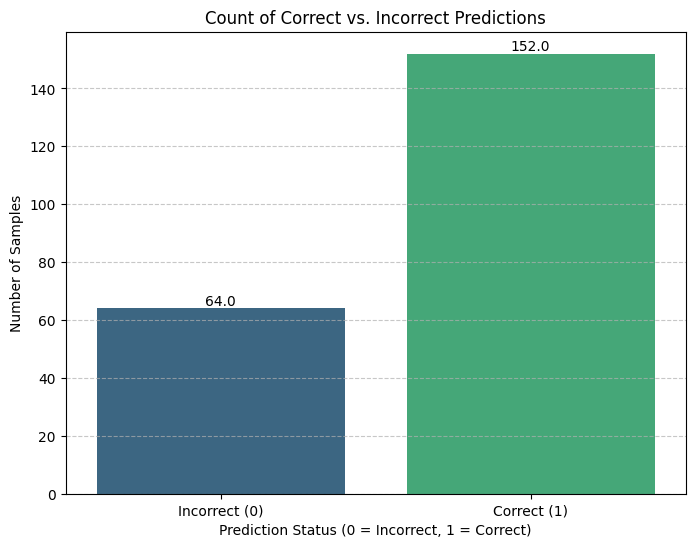

In [125]:
# Print y_test and y_pred (original team names for clarity)
print("\n--- y_test vs y_pred ---")
# Create a DataFrame for easy comparison
comparison_df = pd.DataFrame({
    'Actual Winner': y_test_original,
    'Predicted Winner': y_pred_original
})
# Add a column indicating if the prediction was correct
comparison_df['Correct Prediction'] = (comparison_df['Actual Winner'] == comparison_df['Predicted Winner']).astype(int)
print(comparison_df)

# Plotting the histogram of correct vs. incorrect predictions
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Correct Prediction', data=comparison_df, palette='viridis')
plt.title('Count of Correct vs. Incorrect Predictions')
plt.xlabel('Prediction Status (0 = Incorrect, 1 = Correct)')
plt.ylabel('Number of Samples')
plt.xticks(ticks=[0, 1], labels=['Incorrect (0)', 'Correct (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()



--- Prediction Error Analysis ---

Confusion Matrix:


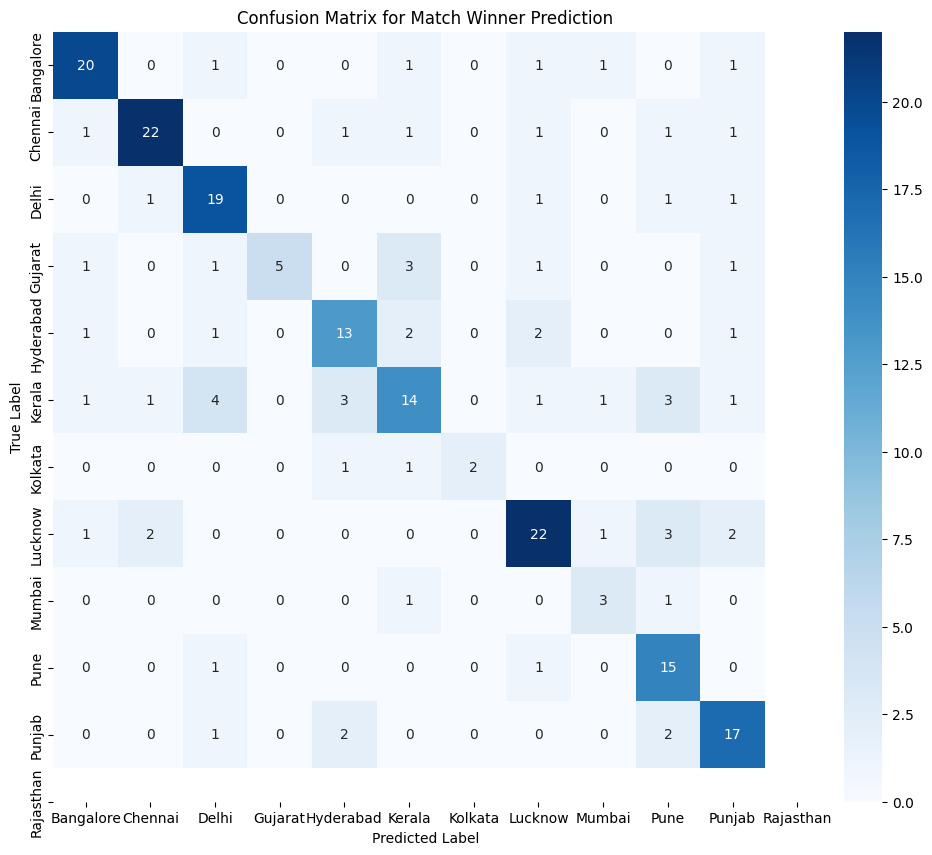

In [126]:
# Extensive Prediction Error Analysis
print("\n--- Prediction Error Analysis ---")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_original, y_pred_original)
# Get class labels in the order they appear in the confusion matrix
class_labels = target_label_encoder.classes_
print("\nConfusion Matrix:")
# Plotting the confusion matrix for better interpretability
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Match Winner Prediction')
plt.show()




--- Feature Importance ---

Feature Importances (Top 15):
team2              0.198707
team1              0.194679
toss_winner        0.129673
venue              0.074673
season             0.057823
toss_decision      0.042853
inning2_wickets    0.042559
inning1_runs       0.037543
player_of_match    0.036630
inning2_balls      0.032535
inning2_runs       0.029508
inning1_balls      0.027128
umpire1            0.025519
inning1_wickets    0.023997
city               0.023813
dtype: float32


/tmp/ipython-input-127-1134360786.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=features_df.values, y=features_df.index, palette='viridis')


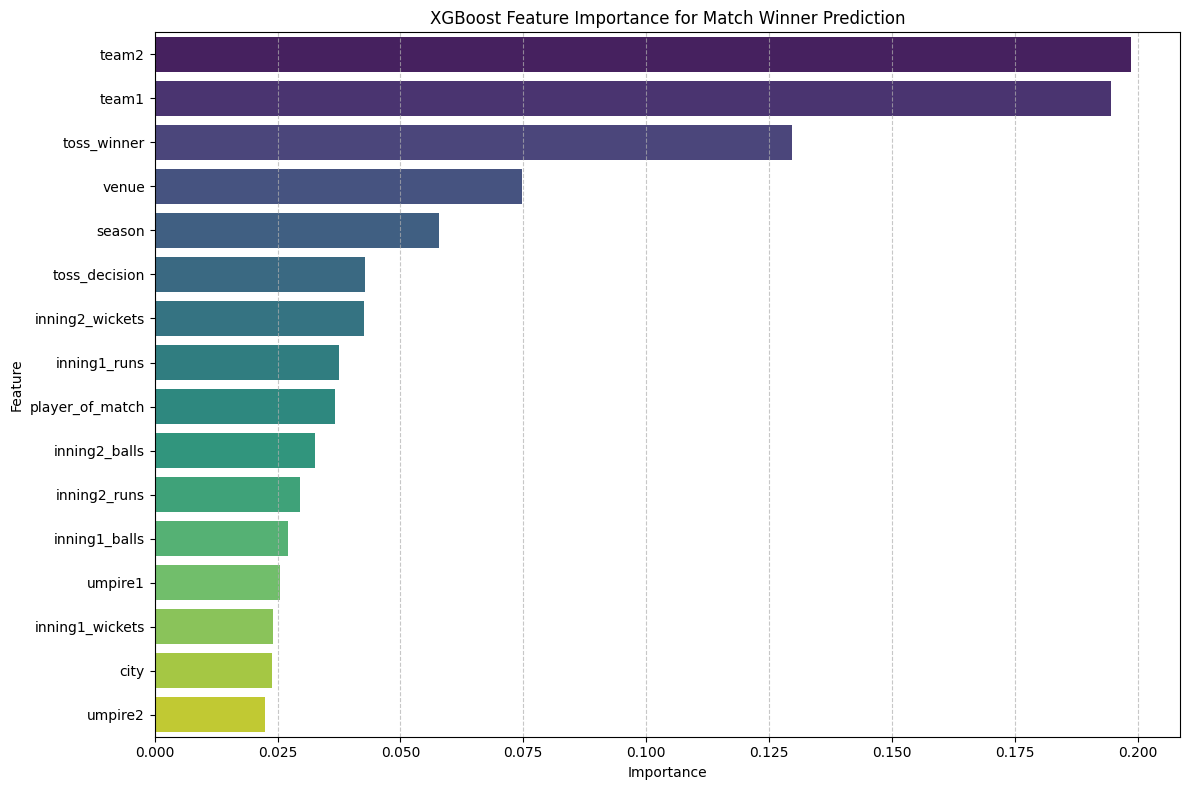


Total misclassified samples: 64

Some Misclassified Examples (Actual vs. Predicted):
Sample 5: Actual='Lucknow', Predicted='Hyderabad'
Sample 8: Actual='Bangalore', Predicted='Kolkata'
Sample 15: Actual='Mumbai', Predicted='Chennai'
Sample 16: Actual='Mumbai', Predicted='Rajasthan'
Sample 17: Actual='Kolkata', Predicted='Hyderabad'
Sample 28: Actual='Chennai', Predicted='Hyderabad'
Sample 34: Actual='Mumbai', Predicted='Punjab'
Sample 38: Actual='Hyderabad', Predicted='Mumbai'
Sample 39: Actual='Bangalore', Predicted='Delhi'
Sample 41: Actual='Hyderabad', Predicted='Kolkata'

--- End of Error Analysis ---


In [127]:
# Feature Importance
print("\n--- Feature Importance ---")
# Get feature importances from the trained model
feature_importances = model.feature_importances_

# Create a Series with feature names and their importances
features_df = pd.Series(feature_importances, index=X.columns)

# Sort the features by importance in descending order
features_df = features_df.sort_values(ascending=False)

print("\nFeature Importances (Top 15):")
print(features_df.head(15))

# Plotting feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=features_df.values, y=features_df.index, palette='viridis')
plt.title('XGBoost Feature Importance for Match Winner Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# Identify misclassified examples (up to 10 for demonstration)
misclassified_indices = np.where(y_test_original != y_pred_original)[0]
print(f"\nTotal misclassified samples: {len(misclassified_indices)}")

if len(misclassified_indices) > 0:
    print("\nSome Misclassified Examples (Actual vs. Predicted):")
    # Take a sample of misclassified indices if there are too many
    sample_misclassified_indices = misclassified_indices[:min(len(misclassified_indices), 10)]

    for i in sample_misclassified_indices:
        actual_winner = y_test_original[i]
        predicted_winner = y_pred_original[i]
        # You might want to print some features of the misclassified sample here
        # E.g., X_test.iloc[i]
        print(f"Sample {i+1}: Actual='{actual_winner}', Predicted='{predicted_winner}'")
else:
    print("\nNo misclassified samples found in the test set. (This is rare with real data)")

print("\n--- End of Error Analysis ---")

1. Address Data Leakage (Highest Priority)
Current Problem:

player_of_match: This is a major data leakage! The "player of the match" is decided after the match is over and the winner is known. Including it as a feature means your model essentially knows the outcome.
inning2_runs, inning2_wickets, inning2_balls: If your goal is to predict the winner before the match starts or after the first innings but before the second innings is played, then these features are also leakage, as they describe the outcome of the second innings which hasn't happened yet at the prediction point. If you intend to predict the winner after both innings are completed but before the 'winner' is explicitly declared to the model, then these might be acceptable, but it's a less challenging prediction problem. Given your comment about "lower prediction capabilities," it suggests you want a harder, more realistic prediction scenario.

### Removing innings 2 & Player of the match data and predicting our winner as they leak  winner before winner is actually predicted by the model

In [128]:
# --- Load the new aggregated dataset ---
# Using 'aggregated_match_data_by_innings.csv' as requested
df = pd.read_csv('aggregated_match_data_by_innings.csv')

In [129]:


print("New Aggregated Dataset Info:")
df.info()
print("\nFirst 5 rows of new aggregated dataset:")
print(df.head())
print("-" * 30)

# Define the target column
target = 'winner'

# --- Updated Features based on provided column list and removing data leakage ---
# Removed 'inning2_runs', 'inning2_wickets', 'inning2_balls', and 'player_of_match'
# Added 'team1' and 'team2'
features = [
    'inning1_runs', 'inning1_wickets', 'inning1_balls',
    'season', 'city', 'venue', 'toss_winner', 'toss_decision',
    'umpire1', 'umpire2',
    'team1', 'team2'
]

New Aggregated Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1090 entries, 0 to 1089
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       1090 non-null   int64 
 1   id               1090 non-null   int64 
 2   inning1_runs     1090 non-null   int64 
 3   inning1_wickets  1090 non-null   int64 
 4   inning1_balls    1090 non-null   int64 
 5   inning2_runs     1090 non-null   int64 
 6   inning2_wickets  1090 non-null   int64 
 7   inning2_balls    1090 non-null   int64 
 8   season           1090 non-null   int64 
 9   city             1090 non-null   object
 10  venue            1090 non-null   object
 11  toss_winner      1090 non-null   object
 12  toss_decision    1090 non-null   object
 13  team1            1090 non-null   object
 14  team2            1090 non-null   object
 15  winner           1090 non-null   object
 16  result           1090 non-null   object
 17  umpi

In [130]:

# Ensure only selected features and target are in the DataFrame, and drop NaNs
df_selected = df[features + [target]].dropna().copy() # .copy() to avoid SettingWithCopyWarning


print("\nDataFrame Info after column selection and dropping NaNs:")
df_selected.info()
print("\nFirst 5 rows after selection and dropping NaNs (using new features):")
print(df_selected.head())
print("-" * 30)


DataFrame Info after column selection and dropping NaNs:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1090 entries, 0 to 1089
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   inning1_runs     1090 non-null   int64 
 1   inning1_wickets  1090 non-null   int64 
 2   inning1_balls    1090 non-null   int64 
 3   season           1090 non-null   int64 
 4   city             1090 non-null   object
 5   venue            1090 non-null   object
 6   toss_winner      1090 non-null   object
 7   toss_decision    1090 non-null   object
 8   umpire1          1090 non-null   object
 9   umpire2          1090 non-null   object
 10  team1            1090 non-null   object
 11  team2            1090 non-null   object
 12  winner           1090 non-null   object
dtypes: int64(4), object(9)
memory usage: 110.8+ KB

First 5 rows after selection and dropping NaNs (using new features):
   inning1_runs  inning1_wickets  inni

In [131]:
# Separate features (X) and target (y)
X = df_selected[features]
y = df_selected[target]

print(f"\nShape of features (X): {X.shape}")
print(f"Shape of target (y): {y.shape}")
print("-" * 30)

# Initialize LabelEncoder for the target column first, to get classes for inverse transformation later
target_label_encoder = LabelEncoder()
y_encoded = target_label_encoder.fit_transform(y)

# Store encoders for each column
feature_encoders = {}
# Encode categorical features in X
for column in X.columns:
    if X[column].dtype == 'object':
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column])
        feature_encoders[column] = le # Store the encoder for potential inverse transform if needed
        print(f"Encoded categorical feature: '{column}'")

print("\nX (features) after encoding categorical columns (first 5 rows):")
print(X.head())
print("\ny (target) after encoding 'winner' column (first 5 values):")
print(pd.Series(y_encoded).head())
print("-" * 30)

# --- Loop through different test_size values ---
test_sizes = np.arange(0.15, 0.41, 0.05) # From 0.15 to 0.40 with step of 0.05

all_accuracies = {}
all_reports = {}

for test_size in test_sizes:
    print(f"\n--- Running model with test_size = {test_size:.2f} ---")

    # Split the data into training and testing sets
    X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=test_size, random_state=42)

    # Initialize the XGBClassifier with simple parameters
    model = XGBClassifier(eval_metric='mlogloss', random_state=42)

    # Train the model
    model.fit(X_train, y_train_encoded)

    # Make predictions on the test set
    y_pred_encoded = model.predict(X_test)

    # Convert encoded predictions and true values back to original team names for better readability
    y_test_original = target_label_encoder.inverse_transform(y_test_encoded)
    y_pred_original = target_label_encoder.inverse_transform(y_pred_encoded)

    # Evaluate the model
    accuracy = accuracy_score(y_test_original, y_pred_original)
    report = classification_report(y_test_original, y_pred_original, zero_division=0)

    all_accuracies[test_size] = accuracy
    all_reports[test_size] = report

    print(f"\nAccuracy Score for test_size {test_size:.2f}: {accuracy:.4f}")
    print(f"\nClassification Report for test_size {test_size:.2f}:\n", report)

    # Store results for the last iteration to plot detailed analyses later
    if test_size == test_sizes[-1]:
        final_y_test_original = y_test_original
        final_y_pred_original = y_pred_original
        final_X_test = X_test
        final_model = model

print("\n--- Summary of Accuracies across different test_sizes ---")
for ts, acc in all_accuracies.items():
    print(f"Test Size: {ts:.2f}, Accuracy: {acc:.4f}")

print("\n--- Detailed Analysis for the last test_size (0.40) ---")





Shape of features (X): (1090, 12)
Shape of target (y): (1090,)
------------------------------
Encoded categorical feature: 'city'
Encoded categorical feature: 'venue'
Encoded categorical feature: 'toss_winner'
Encoded categorical feature: 'toss_decision'
Encoded categorical feature: 'umpire1'
Encoded categorical feature: 'umpire2'
Encoded categorical feature: 'team1'
Encoded categorical feature: 'team2'

X (features) after encoding categorical columns (first 5 rows):
   inning1_runs  inning1_wickets  inning1_balls  season  city  venue  \
0           222                3            124    2008     2     18   
1           240                5            124    2008     7     29   
2           129                8            122    2008    10     12   
3           165                7            123    2008    26     41   
4           110               10            118    2008    23     11   

   toss_winner  toss_decision  umpire1  umpire2  team1  team2  
0            0              1 

/tmp/ipython-input-131-894765749.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
/tmp/ipython-input-131-894765749.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
/tmp/ipython-input-131-894765749.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-


Accuracy Score for test_size 0.15: 0.5671

Classification Report for test_size 0.15:
               precision    recall  f1-score   support

   Bangalore       0.57      0.57      0.57        21
     Chennai       0.75      0.75      0.75        28
       Delhi       0.57      0.81      0.67        16
     Gujarat       1.00      0.64      0.78        11
   Hyderabad       0.43      0.60      0.50        10
      Kerala       0.00      0.00      0.00         1
     Kolkata       0.50      0.39      0.44        18
     Lucknow       0.50      0.50      0.50         2
      Mumbai       0.69      0.50      0.58        22
        Pune       0.20      0.50      0.29         4
      Punjab       0.50      0.38      0.43        16
   Rajasthan       0.41      0.47      0.44        15

    accuracy                           0.57       164
   macro avg       0.51      0.51      0.49       164
weighted avg       0.59      0.57      0.57       164


--- Running model with test_size = 0.20 ---




--- y_test vs y_pred ---
    Actual Winner Predicted Winner  Correct Prediction
0         Chennai          Chennai                   1
1          Mumbai           Mumbai                   1
2       Bangalore        Bangalore                   1
3         Kolkata          Chennai                   0
4           Delhi        Rajasthan                   0
..            ...              ...                 ...
432       Chennai        Rajasthan                   0
433        Punjab           Punjab                   1
434     Bangalore        Rajasthan                   0
435     Bangalore        Rajasthan                   0
436         Delhi           Punjab                   0

[437 rows x 3 columns]


/tmp/ipython-input-132-4155474616.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Correct Prediction', data=comparison_df, palette='viridis')


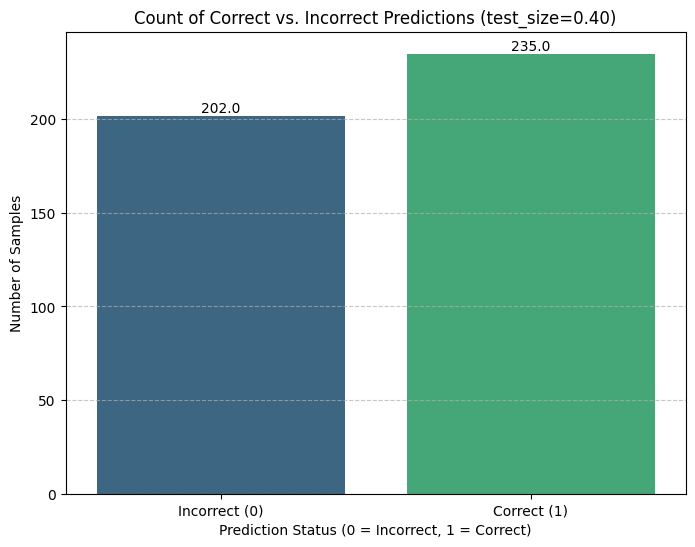

In [132]:
# Print y_test and y_pred (original team names for clarity) from the last iteration
print("\n--- y_test vs y_pred ---")
# Create a DataFrame for easy comparison
comparison_df = pd.DataFrame({
    'Actual Winner': final_y_test_original,
    'Predicted Winner': final_y_pred_original
})
# Add a column indicating if the prediction was correct
comparison_df['Correct Prediction'] = (comparison_df['Actual Winner'] == comparison_df['Predicted Winner']).astype(int)
print(comparison_df)

# Plotting the histogram of correct vs. incorrect predictions
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Correct Prediction', data=comparison_df, palette='viridis')
plt.title(f'Count of Correct vs. Incorrect Predictions (test_size={test_sizes[-1]:.2f})')
plt.xlabel('Prediction Status (0 = Incorrect, 1 = Correct)')
plt.ylabel('Number of Samples')
plt.xticks(ticks=[0, 1], labels=['Incorrect (0)', 'Correct (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()





--- Prediction Error Analysis ---

Confusion Matrix:


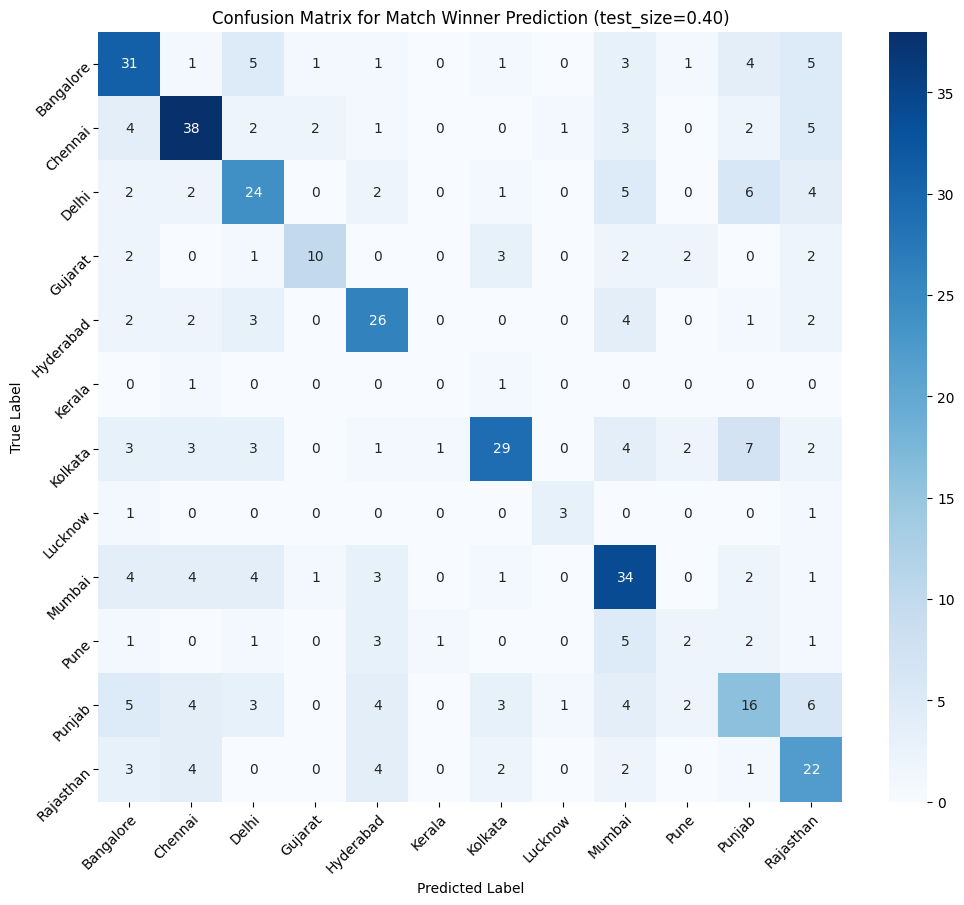

In [133]:
# Extensive Prediction Error Analysis
print("\n--- Prediction Error Analysis ---")

# Confusion Matrix
conf_matrix = confusion_matrix(final_y_test_original, final_y_pred_original)
# Get class labels in the order they appear in the confusion matrix
class_labels = target_label_encoder.classes_
print("\nConfusion Matrix:")
# Plotting the confusion matrix for better interpretability
plt.figure(figsize=(12, 10))
ax_conf_matrix = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for Match Winner Prediction (test_size={test_sizes[-1]:.2f})')

# Rotate x and y axis labels
plt.setp(ax_conf_matrix.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax_conf_matrix.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()


--- Feature Importance ---

Feature Importances (Top 15):
toss_winner        0.226940
team1              0.214936
team2              0.190174
venue              0.064053
season             0.061996
inning1_balls      0.042632
inning1_runs       0.040473
toss_decision      0.037159
city               0.034825
umpire1            0.031095
umpire2            0.029753
inning1_wickets    0.025963
dtype: float32


/tmp/ipython-input-134-2702995009.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=features_df.values, y=features_df.index, palette='viridis')


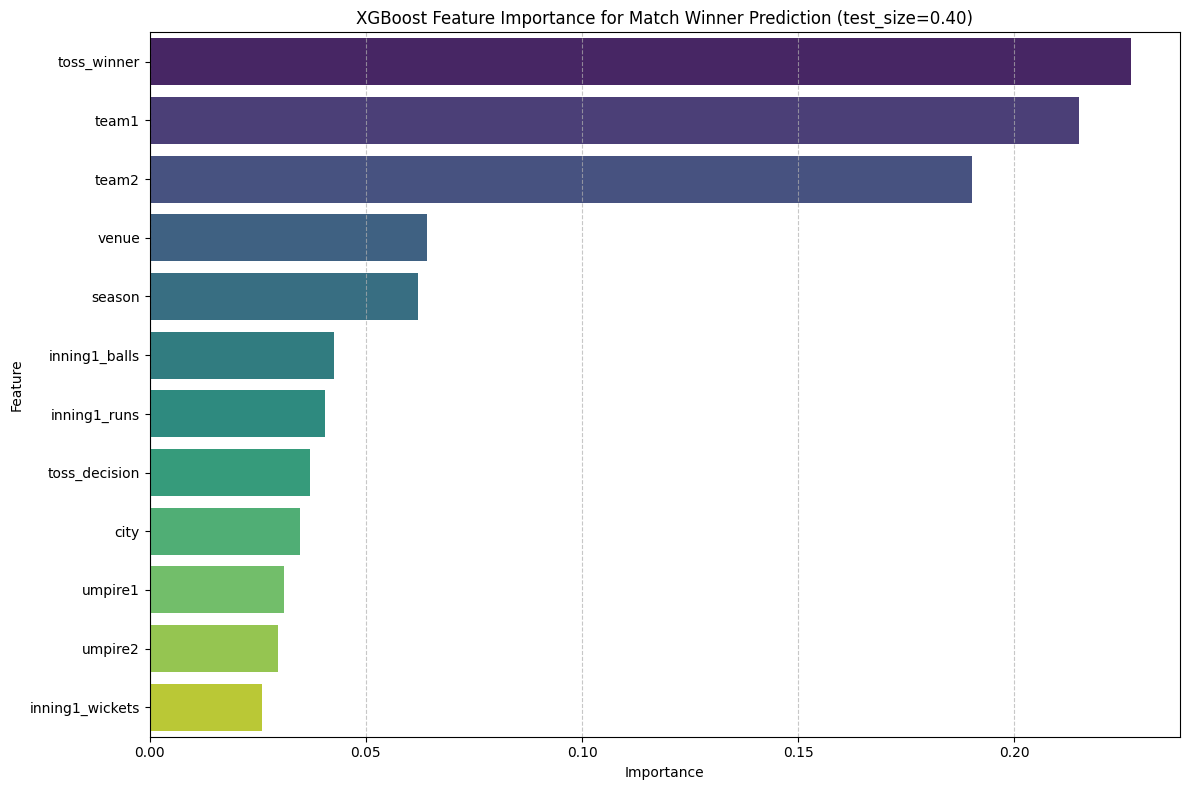


Total misclassified samples: 202

Some Misclassified Examples (Actual vs. Predicted):
Sample 4: Actual='Kolkata', Predicted='Chennai'
Sample 5: Actual='Delhi', Predicted='Rajasthan'
Sample 7: Actual='Punjab', Predicted='Pune'
Sample 8: Actual='Kerala', Predicted='Chennai'
Sample 9: Actual='Punjab', Predicted='Bangalore'
Sample 12: Actual='Gujarat', Predicted='Kolkata'
Sample 13: Actual='Kolkata', Predicted='Punjab'
Sample 15: Actual='Punjab', Predicted='Pune'
Sample 16: Actual='Punjab', Predicted='Chennai'
Sample 22: Actual='Chennai', Predicted='Bangalore'

--- End of Error Analysis ---


In [134]:
# Feature Importance
print("\n--- Feature Importance ---")
# Get feature importances from the trained model
feature_importances = final_model.feature_importances_

# Create a Series with feature names and their importances
features_df = pd.Series(feature_importances, index=X.columns) # Use X.columns from the full dataset

# Sort the features by importance in descending order
features_df = features_df.sort_values(ascending=False)

print("\nFeature Importances (Top 15):")
print(features_df.head(15))

# Plotting feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=features_df.values, y=features_df.index, palette='viridis')
plt.title(f'XGBoost Feature Importance for Match Winner Prediction (test_size={test_sizes[-1]:.2f})')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# Identify misclassified examples (up to 10 for demonstration)
misclassified_indices = np.where(final_y_test_original != final_y_pred_original)[0]
print(f"\nTotal misclassified samples: {len(misclassified_indices)}")

if len(misclassified_indices) > 0:
    print("\nSome Misclassified Examples (Actual vs. Predicted):")
    # Take a sample of misclassified indices if there are too many
    sample_misclassified_indices = misclassified_indices[:min(len(misclassified_indices), 10)]

    for i in sample_misclassified_indices:
        actual_winner = final_y_test_original[i]
        predicted_winner = final_y_pred_original[i]
        # You might want to print some features of the misclassified sample here
        # E.g., final_X_test.iloc[i]
        print(f"Sample {i+1}: Actual='{actual_winner}', Predicted='{predicted_winner}'")
else:
    print("\nNo misclassified samples found in the test set. (This is rare with real data)")

print("\n--- End of Error Analysis ---")

## Removing 4 teams with only 1/2 seasons data teams aggregated match by match dataset

In [135]:
df = pd.read_csv('aggregated_match_data_by_innings_wo_small_dataset.csv')

print(" Aggregated Dataset Info w/o small teams:")
df.info()


 Aggregated Dataset Info w/o small teams:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       893 non-null    int64 
 1   id               893 non-null    int64 
 2   inning1_runs     893 non-null    int64 
 3   inning1_wickets  893 non-null    int64 
 4   inning1_balls    893 non-null    int64 
 5   inning2_runs     893 non-null    int64 
 6   inning2_wickets  893 non-null    int64 
 7   inning2_balls    893 non-null    int64 
 8   season           893 non-null    int64 
 9   city             893 non-null    object
 10  venue            893 non-null    object
 11  toss_winner      893 non-null    object
 12  toss_decision    893 non-null    object
 13  team1            893 non-null    object
 14  team2            893 non-null    object
 15  winner           893 non-null    object
 16  result           893 non-null    objec

In [136]:
print("\nFirst 5 rows of new aggregated dataset:")
print(df.head())
print("-" * 30)
# Define the target column
target = 'winner'


First 5 rows of new aggregated dataset:
   Unnamed: 0      id  inning1_runs  inning1_wickets  inning1_balls  \
0           0  335982           222                3            124   
1           1  335983           240                5            124   
2           2  335984           129                8            122   
3           3  335985           165                7            123   
4           4  335986           110               10            118   

   inning2_runs  inning2_wickets  inning2_balls  season        city  \
0            82               10            101    2008   Bangalore   
1           207                4            124    2008  Chandigarh   
2           132                1             97    2008       Delhi   
3           166                5            123    2008      Mumbai   
4           112                5            122    2008     Kolkata   

                                        venue toss_winner toss_decision  \
0                       M Chin

In [137]:
# Removed 'inning2_runs', 'inning2_wickets', 'inning2_balls', and 'player_of_match'
# Added 'team1' and 'team2'
features = [
    'inning1_runs', 'inning1_wickets', 'inning1_balls',
    'season', 'city', 'venue', 'toss_winner', 'toss_decision',
    'umpire1', 'umpire2',
    'team1', 'team2'
]

# Ensure only selected features and target are in the DataFrame, and drop NaNs
df_selected = df[features + [target]].dropna().copy() # .copy() to avoid SettingWithCopyWarning


In [138]:
# --- Updated Features based on provided column list and removing data leakage ---
print("\nDataFrame Info after column selection and dropping NaNs:")
df_selected.info()
print("\nFirst 5 rows after selection and dropping NaNs (using new features):")
print(df_selected.head())
print("-" * 30)
# Separate features (X) and target (y)
X = df_selected[features]
y = df_selected[target]

print(f"\nShape of features (X): {X.shape}")
print(f"Shape of target (y): {y.shape}")
print("-" * 30)


DataFrame Info after column selection and dropping NaNs:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   inning1_runs     893 non-null    int64 
 1   inning1_wickets  893 non-null    int64 
 2   inning1_balls    893 non-null    int64 
 3   season           893 non-null    int64 
 4   city             893 non-null    object
 5   venue            893 non-null    object
 6   toss_winner      893 non-null    object
 7   toss_decision    893 non-null    object
 8   umpire1          893 non-null    object
 9   umpire2          893 non-null    object
 10  team1            893 non-null    object
 11  team2            893 non-null    object
 12  winner           893 non-null    object
dtypes: int64(4), object(9)
memory usage: 90.8+ KB

First 5 rows after selection and dropping NaNs (using new features):
   inning1_runs  inning1_wickets  inning1

In [139]:
# Initialize LabelEncoder for the target column first, to get classes for inverse transformation later
target_label_encoder = LabelEncoder()
y_encoded = target_label_encoder.fit_transform(y)

# Store encoders for each column
feature_encoders = {}
# Encode categorical features in X
for column in X.columns:
    if X[column].dtype == 'object':
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column])
        feature_encoders[column] = le # Store the encoder for potential inverse transform if needed
        print(f"Encoded categorical feature: '{column}'")

print("\nX (features) after encoding categorical columns (first 5 rows):")
print(X.head())
print("\ny (target) after encoding 'winner' column (first 5 values):")
print(pd.Series(y_encoded).head())
print("-" * 30)

Encoded categorical feature: 'city'
Encoded categorical feature: 'venue'
Encoded categorical feature: 'toss_winner'
Encoded categorical feature: 'toss_decision'
Encoded categorical feature: 'umpire1'
Encoded categorical feature: 'umpire2'
Encoded categorical feature: 'team1'
Encoded categorical feature: 'team2'

X (features) after encoding categorical columns (first 5 rows):
   inning1_runs  inning1_wickets  inning1_balls  season  city  venue  \
0           222                3            124    2008     2     16   
1           240                5            124    2008     7     26   
2           129                8            122    2008    10     11   
3           165                7            123    2008    23     37   
4           110               10            118    2008    21     10   

   toss_winner  toss_decision  umpire1  umpire2  team1  team2  
0            0              1        9       41      0      4  
1            1              0       34       52      6      1

/tmp/ipython-input-139-1204039196.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
/tmp/ipython-input-139-1204039196.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
/tmp/ipython-input-139-1204039196.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand


--- Running model with test_size = 0.15 ---

Accuracy Score for test_size 0.15: 0.5522

Classification Report for test_size 0.15:
               precision    recall  f1-score   support

   Bangalore       0.69      0.53      0.60        17
     Chennai       0.70      0.94      0.80        17
       Delhi       0.40      0.29      0.33        14
   Hyderabad       0.73      0.47      0.57        17
     Kolkata       0.46      0.69      0.55        16
      Mumbai       0.64      0.62      0.63        29
      Punjab       0.21      0.27      0.24        11
   Rajasthan       0.45      0.38      0.42        13

    accuracy                           0.55       134
   macro avg       0.54      0.52      0.52       134
weighted avg       0.57      0.55      0.55       134


--- Running model with test_size = 0.20 ---

Accuracy Score for test_size 0.20: 0.5866

Classification Report for test_size 0.20:
               precision    recall  f1-score   support

   Bangalore       0.59      0

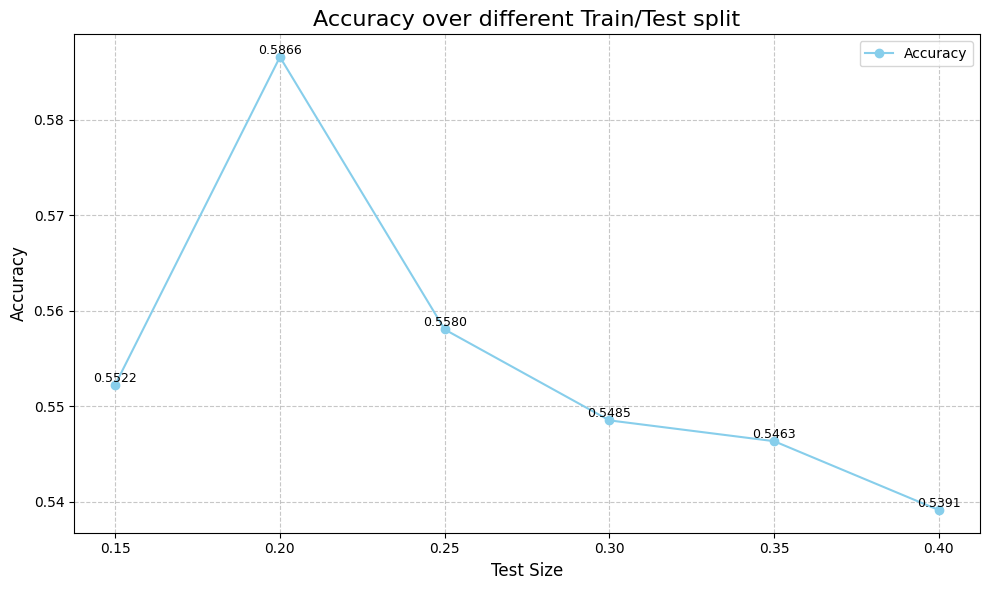


--- Summary of Accuracies across different test_sizes ---
Test Size: 0.15, Accuracy: 0.5522
Test Size: 0.20, Accuracy: 0.5866
Test Size: 0.25, Accuracy: 0.5580
Test Size: 0.30, Accuracy: 0.5485
Test Size: 0.35, Accuracy: 0.5463
Test Size: 0.40, Accuracy: 0.5391

--- Detailed Analysis for the last test_size (0.40) ---


In [140]:


# --- Loop through different test_size values ---
test_sizes = np.arange(0.15, 0.41, 0.05) # From 0.15 to 0.40 with step of 0.05

all_accuracies = {}
all_reports = {}

for test_size in test_sizes:
    print(f"\n--- Running model with test_size = {test_size:.2f} ---")

    # Split the data into training and testing sets
    X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=test_size, random_state=42)

    # Initialize the XGBClassifier with simple parameters
    model = XGBClassifier(eval_metric='mlogloss', random_state=42)

    # Train the model
    model.fit(X_train, y_train_encoded)

    # Make predictions on the test set
    y_pred_encoded = model.predict(X_test)

    # Convert encoded predictions and true values back to original team names for better readability
    y_test_original = target_label_encoder.inverse_transform(y_test_encoded)
    y_pred_original = target_label_encoder.inverse_transform(y_pred_encoded)

    # Evaluate the model
    accuracy = accuracy_score(y_test_original, y_pred_original)
    report = classification_report(y_test_original, y_pred_original, zero_division=0)

    all_accuracies[test_size] = accuracy
    all_reports[test_size] = report

    print(f"\nAccuracy Score for test_size {test_size:.2f}: {accuracy:.4f}")
    print(f"\nClassification Report for test_size {test_size:.2f}:\n", report)

    # Store results for the last iteration to plot detailed analyses later
    if test_size == test_sizes[-1]:
        final_y_test_original = y_test_original
        final_y_pred_original = y_pred_original
        final_X_test = X_test
        final_model = model

test_sizes = list(all_accuracies.keys())
accuracies = list(all_accuracies.values())
# Create the plot
plt.figure(figsize=(10, 6)) # Set the figure size for better readability
plt.plot(test_sizes, accuracies, marker='o', linestyle='-', color='skyblue', label='Accuracy')

# Add titles and labels
plt.title('Accuracy over different Train/Test split', fontsize=16)
plt.xlabel('Test Size', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add labels to data points
for ts, acc in all_accuracies.items():
    plt.text(ts, acc, f'{acc:.4f}', ha='center', va='bottom', fontsize=9)

# Add a legend
plt.legend()

# Set x-axis ticks to match test sizes more precisely if they are few
plt.xticks(test_sizes)

# Display the plot
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()
print("\n--- Summary of Accuracies across different test_sizes ---")
for ts, acc in all_accuracies.items():
    print(f"Test Size: {ts:.2f}, Accuracy: {acc:.4f}")

print("\n--- Detailed Analysis for the last test_size (0.40) ---")


--- y_test vs y_pred ---
    Actual Winner Predicted Winner  Correct Prediction
0           Delhi           Mumbai                   0
1         Kolkata          Kolkata                   1
2       Hyderabad           Mumbai                   0
3          Mumbai        Rajasthan                   0
4          Mumbai           Mumbai                   1
..            ...              ...                 ...
353       Chennai          Chennai                   1
354     Bangalore           Mumbai                   0
355     Bangalore        Rajasthan                   0
356       Kolkata          Kolkata                   1
357        Mumbai           Mumbai                   1

[358 rows x 3 columns]


/tmp/ipython-input-141-2518404890.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Correct Prediction', data=comparison_df, palette='viridis')


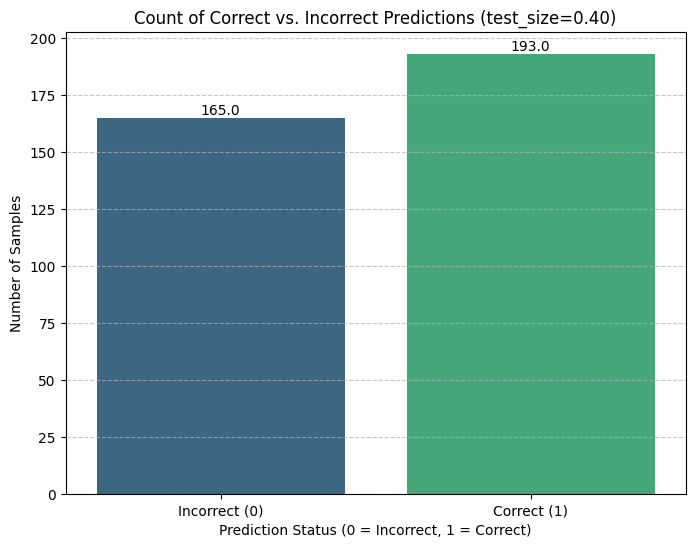

In [141]:
# Print y_test and y_pred (original team names for clarity) from the last iteration
print("\n--- y_test vs y_pred ---")
# Create a DataFrame for easy comparison
comparison_df = pd.DataFrame({
    'Actual Winner': final_y_test_original,
    'Predicted Winner': final_y_pred_original
})
# Add a column indicating if the prediction was correct
comparison_df['Correct Prediction'] = (comparison_df['Actual Winner'] == comparison_df['Predicted Winner']).astype(int)
print(comparison_df)

# Plotting the histogram of correct vs. incorrect predictions
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Correct Prediction', data=comparison_df, palette='viridis')
plt.title(f'Count of Correct vs. Incorrect Predictions (test_size={test_sizes[-1]:.2f})')
plt.xlabel('Prediction Status (0 = Incorrect, 1 = Correct)')
plt.ylabel('Number of Samples')
plt.xticks(ticks=[0, 1], labels=['Incorrect (0)', 'Correct (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()


--- Prediction Error Analysis ---

Confusion Matrix:


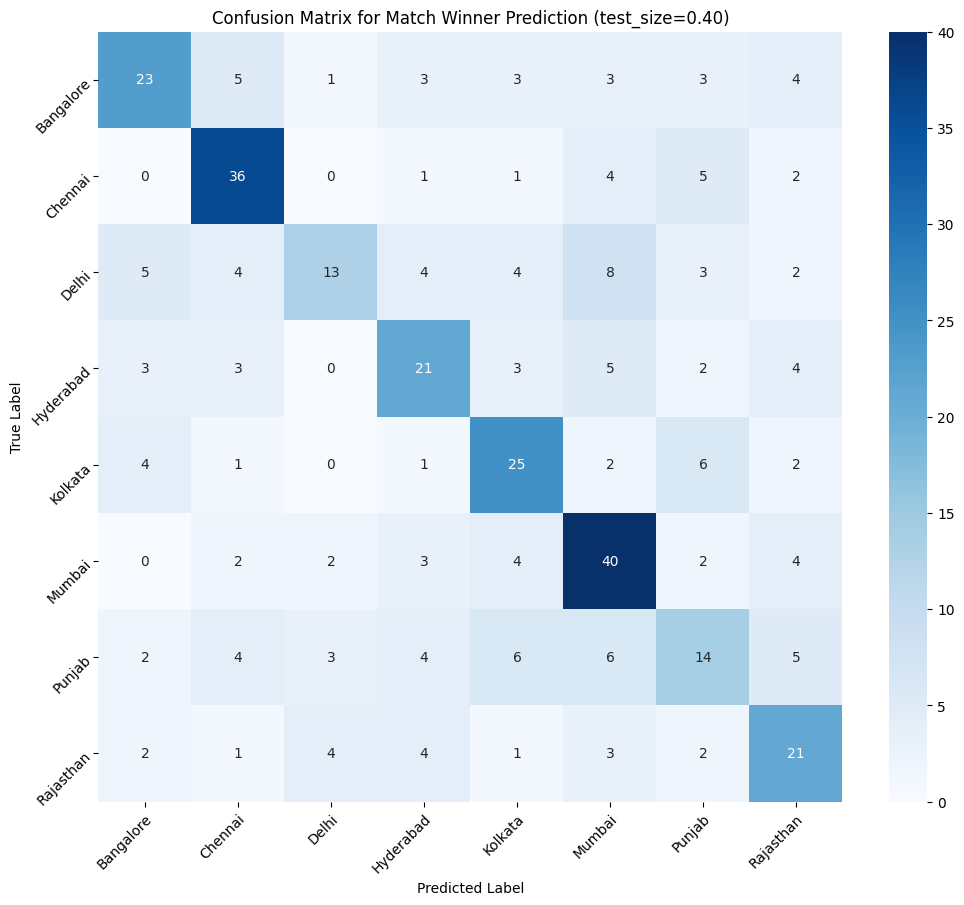

In [142]:
# Extensive Prediction Error Analysis
print("\n--- Prediction Error Analysis ---")

# Confusion Matrix
conf_matrix = confusion_matrix(final_y_test_original, final_y_pred_original)
# Get class labels in the order they appear in the confusion matrix
class_labels = target_label_encoder.classes_
print("\nConfusion Matrix:")
# Plotting the confusion matrix for better interpretability
plt.figure(figsize=(12, 10))
ax_conf_matrix = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for Match Winner Prediction (test_size={test_sizes[-1]:.2f})')

# Rotate x and y axis labels
plt.setp(ax_conf_matrix.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax_conf_matrix.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()


--- Feature Importance ---

Feature Importances (Top 15):
team2              0.254961
team1              0.242891
toss_winner        0.113868
venue              0.086879
inning1_runs       0.044521
season             0.044515
city               0.041137
inning1_balls      0.036202
inning1_wickets    0.035525
umpire2            0.034752
umpire1            0.034649
toss_decision      0.030100
dtype: float32


/tmp/ipython-input-143-2194850176.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=features_df.values, y=features_df.index, palette='viridis')


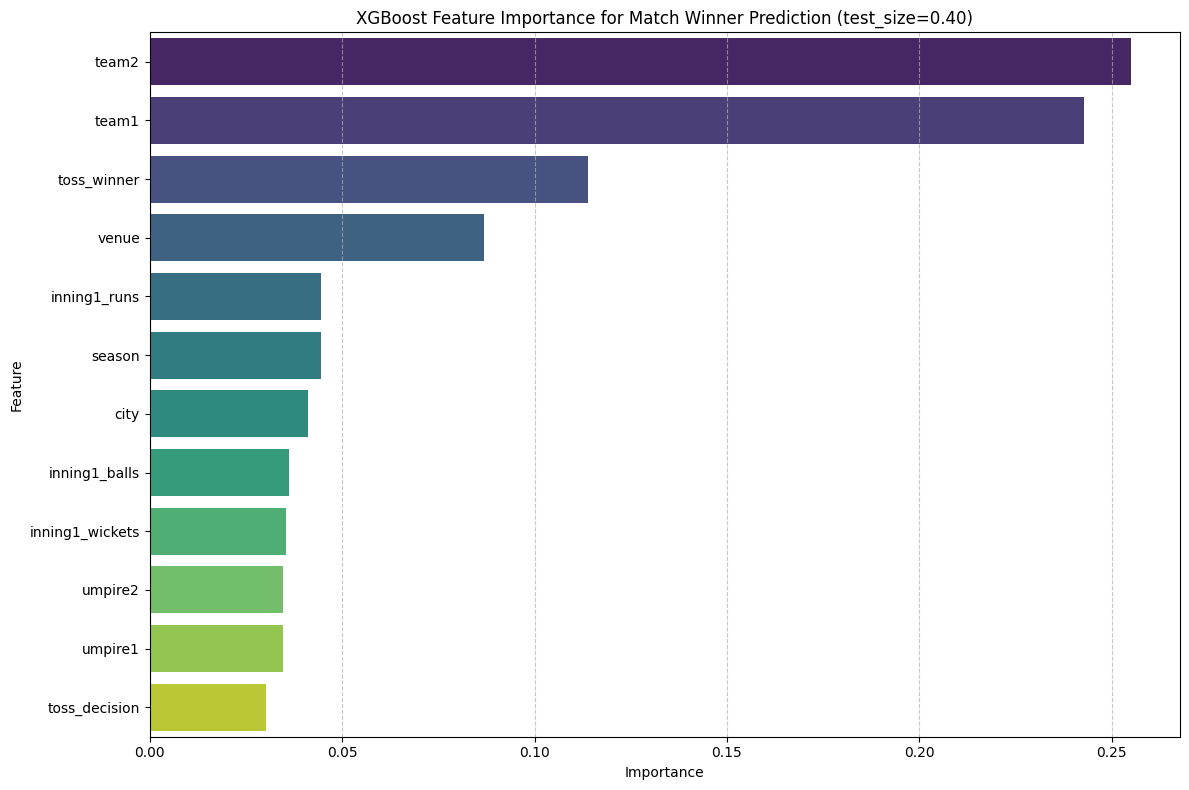

In [143]:
# Feature Importance
print("\n--- Feature Importance ---")
# Get feature importances from the trained model
feature_importances = final_model.feature_importances_

# Create a Series with feature names and their importances
features_df = pd.Series(feature_importances, index=X.columns) # Use X.columns from the full dataset

# Sort the features by importance in descending order
features_df = features_df.sort_values(ascending=False)

print("\nFeature Importances (Top 15):")
print(features_df.head(15))

# Plotting feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=features_df.values, y=features_df.index, palette='viridis')
plt.title(f'XGBoost Feature Importance for Match Winner Prediction (test_size={test_sizes[-1]:.2f})')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [144]:
# Identify misclassified examples (up to 10 for demonstration)
misclassified_indices = np.where(final_y_test_original != final_y_pred_original)[0]
print(f"\nTotal misclassified samples: {len(misclassified_indices)}")

if len(misclassified_indices) > 0:
    print("\nSome Misclassified Examples (Actual vs. Predicted):")
    # Take a sample of misclassified indices if there are too many
    sample_misclassified_indices = misclassified_indices[:min(len(misclassified_indices), 10)]

    for i in sample_misclassified_indices:
        actual_winner = final_y_test_original[i]
        predicted_winner = final_y_pred_original[i]
        # You might want to print some features of the misclassified sample here
        # E.g., final_X_test.iloc[i]
        print(f"Sample {i+1}: Actual='{actual_winner}', Predicted='{predicted_winner}'")
else:
    print("\nNo misclassified samples found in the test set. (This is rare with real data)")

print("\n--- End of Error Analysis ---")



Total misclassified samples: 165

Some Misclassified Examples (Actual vs. Predicted):
Sample 1: Actual='Delhi', Predicted='Mumbai'
Sample 3: Actual='Hyderabad', Predicted='Mumbai'
Sample 4: Actual='Mumbai', Predicted='Rajasthan'
Sample 8: Actual='Bangalore', Predicted='Chennai'
Sample 10: Actual='Kolkata', Predicted='Punjab'
Sample 11: Actual='Delhi', Predicted='Bangalore'
Sample 12: Actual='Mumbai', Predicted='Delhi'
Sample 13: Actual='Hyderabad', Predicted='Kolkata'
Sample 14: Actual='Bangalore', Predicted='Rajasthan'
Sample 15: Actual='Delhi', Predicted='Kolkata'

--- End of Error Analysis ---


## Hypertuning the best prediction test/train split XGBClassifier model

In [145]:
## Removing 4 teams with only 1/2 seasons data teams aggregated match by match dataset
df = pd.read_csv('aggregated_match_data_by_innings_wo_small_dataset.csv')

print(" Aggregated Dataset Info w/o small teams:")
df.info()

print("\nFirst 5 rows of new aggregated dataset:")
print(df.head())
print("-" * 30)
# Define the target column
target = 'winner'
# Removed 'inning2_runs', 'inning2_wickets', 'inning2_balls', and 'player_of_match'
# Added 'team1' and 'team2'
features = ['inning1_runs', 'inning1_wickets', 'inning1_balls', 'season', 'city',
       'venue', 'toss_winner', 'toss_decision', 'umpire1', 'umpire2', 'team1',
       'team2']

# Ensure only selected features and target are in the DataFrame, and drop NaNs
df_selected = df[features + [target]].dropna().copy() # .copy() to avoid SettingWithCopyWarning



 Aggregated Dataset Info w/o small teams:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       893 non-null    int64 
 1   id               893 non-null    int64 
 2   inning1_runs     893 non-null    int64 
 3   inning1_wickets  893 non-null    int64 
 4   inning1_balls    893 non-null    int64 
 5   inning2_runs     893 non-null    int64 
 6   inning2_wickets  893 non-null    int64 
 7   inning2_balls    893 non-null    int64 
 8   season           893 non-null    int64 
 9   city             893 non-null    object
 10  venue            893 non-null    object
 11  toss_winner      893 non-null    object
 12  toss_decision    893 non-null    object
 13  team1            893 non-null    object
 14  team2            893 non-null    object
 15  winner           893 non-null    object
 16  result           893 non-null    objec

In [146]:
# --- Updated Features based on provided column list and removing data leakage ---
print("\nDataFrame Info after column selection and dropping NaNs:")
df_selected.info()
print("\nFirst 5 rows after selection and dropping NaNs (using new features):")
print(df_selected.head())
print("-" * 30)


DataFrame Info after column selection and dropping NaNs:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   inning1_runs     893 non-null    int64 
 1   inning1_wickets  893 non-null    int64 
 2   inning1_balls    893 non-null    int64 
 3   season           893 non-null    int64 
 4   city             893 non-null    object
 5   venue            893 non-null    object
 6   toss_winner      893 non-null    object
 7   toss_decision    893 non-null    object
 8   umpire1          893 non-null    object
 9   umpire2          893 non-null    object
 10  team1            893 non-null    object
 11  team2            893 non-null    object
 12  winner           893 non-null    object
dtypes: int64(4), object(9)
memory usage: 90.8+ KB

First 5 rows after selection and dropping NaNs (using new features):
   inning1_runs  inning1_wickets  inning1

In [147]:
# Separate features (X) and target (y)
X = df_selected[features]
y = df_selected[target]

print(f"\nShape of features (X): {X.shape}")
print(f"Shape of target (y): {y.shape}")
print("-" * 30)
# Initialize LabelEncoder for the target column first, to get classes for inverse transformation later
target_label_encoder = LabelEncoder()
y_encoded = target_label_encoder.fit_transform(y)

# Store encoders for each column
feature_encoders = {}
# Encode categorical features in X
for column in X.select_dtypes(include=['object']).columns:
      le = LabelEncoder()
      X[column] = le.fit_transform(X[column])
      feature_encoders[column] = le # Store the encoder for potential inverse transform if needed
      print(f"Encoded categorical feature: '{column}'")

print("\nX (features) after encoding categorical columns (first 5 rows):")
print(X.head())
print("\ny (target) after encoding 'winner' column (first 5 values):")
print(pd.Series(y_encoded).head())
print("-" * 30)



Shape of features (X): (893, 12)
Shape of target (y): (893,)
------------------------------
Encoded categorical feature: 'city'
Encoded categorical feature: 'venue'
Encoded categorical feature: 'toss_winner'
Encoded categorical feature: 'toss_decision'
Encoded categorical feature: 'umpire1'
Encoded categorical feature: 'umpire2'
Encoded categorical feature: 'team1'
Encoded categorical feature: 'team2'

X (features) after encoding categorical columns (first 5 rows):
   inning1_runs  inning1_wickets  inning1_balls  season  city  venue  \
0           222                3            124    2008     2     16   
1           240                5            124    2008     7     26   
2           129                8            122    2008    10     11   
3           165                7            123    2008    23     37   
4           110               10            118    2008    21     10   

   toss_winner  toss_decision  umpire1  umpire2  team1  team2  
0            0              1   

/tmp/ipython-input-147-1036743717.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
/tmp/ipython-input-147-1036743717.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
/tmp/ipython-input-147-1036743717.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [148]:

# --- Set a fixed test_size based on best resulting model ---
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Split the data into training and testing sets
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [149]:
print("\n--- Starting Hyperparameter Tuning with GridSearchCV ---")
# Initialize the XGBClassifier
xgb = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)
# Initialize GridSearchCV
# cv=3 means 3-fold cross-validation.
# n_jobs=-1 uses all available CPU cores to speed up the process.
# verbose=2 prints progress messages.
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
print(X_train.columns)
# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train_encoded)

# Get the best parameters and the best score
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")
print("-" * 30)
# --- END OF HYPERPARAMETER TUNING SECTION ---


# --- Train the final model with the best parameters ---
print("\n--- Training Final Model with Best Parameters ---")
# Initialize the XGBClassifier with the best parameters found by GridSearchCV
best_model = grid_search.best_estimator_

# The best_estimator_ is already fitted on the full training data,
# so you don't necessarily need to call .fit() again.
# You can directly use it for prediction.

# Make predictions on the test set
y_pred_encoded = best_model.predict(X_test)

# Convert encoded predictions and true values back to original team names
y_test_original = target_label_encoder.inverse_transform(y_test_encoded)
y_pred_original = target_label_encoder.inverse_transform(y_pred_encoded)


--- Starting Hyperparameter Tuning with GridSearchCV ---
Index(['inning1_runs', 'inning1_wickets', 'inning1_balls', 'season', 'city',
       'venue', 'toss_winner', 'toss_decision', 'umpire1', 'umpire2', 'team1',
       'team2'],
      dtype='object')
Fitting 3 folds for each of 243 candidates, totalling 729 fits

Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.9}
Best cross-validation accuracy: 0.5518
------------------------------

--- Training Final Model with Best Parameters ---


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:12:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/tmp/ipython-input-150-1422371067.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Correct Prediction', data=comparison_df, palette='viridis')



Accuracy Score for test_size 0.40: 0.5419

Classification Report for test_size 0.40:
               precision    recall  f1-score   support

   Bangalore       0.53      0.45      0.49        20
     Chennai       0.75      0.75      0.75        28
       Delhi       0.36      0.24      0.29        17
   Hyderabad       0.62      0.45      0.53        22
     Kolkata       0.50      0.65      0.57        23
      Mumbai       0.70      0.68      0.69        34
      Punjab       0.14      0.21      0.17        14
   Rajasthan       0.52      0.57      0.55        21

    accuracy                           0.54       179
   macro avg       0.52      0.50      0.50       179
weighted avg       0.56      0.54      0.54       179


--- Detailed Analysis for test_size = 0.20 ---

--- y_test vs y_pred ---
    Actual Winner Predicted Winner  Correct Prediction
0           Delhi           Mumbai                   0
1         Kolkata          Kolkata                   1
2       Hyderabad      

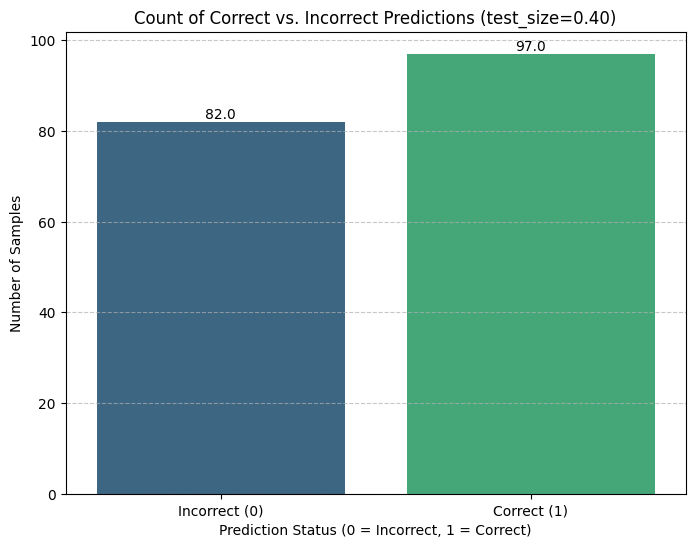

In [150]:
# Evaluate the model
accuracy = accuracy_score(y_test_original, y_pred_original)
report = classification_report(y_test_original, y_pred_original, zero_division=0)

print(f"\nAccuracy Score for test_size {test_size:.2f}: {accuracy:.4f}")
print(f"\nClassification Report for test_size {test_size:.2f}:\n", report)


print("\n--- Detailed Analysis for test_size = 0.20 ---")
# Print y_test and y_pred (original team names for clarity)
print("\n--- y_test vs y_pred ---")
# Create a DataFrame for easy comparison
comparison_df = pd.DataFrame({
    'Actual Winner': y_test_original,
    'Predicted Winner': y_pred_original
})
# Add a column indicating if the prediction was correct
comparison_df['Correct Prediction'] = (comparison_df['Actual Winner'] == comparison_df['Predicted Winner']).astype(int)
print(comparison_df)

# Plotting the histogram of correct vs. incorrect predictions
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Correct Prediction', data=comparison_df, palette='viridis')
plt.title(f'Count of Correct vs. Incorrect Predictions (test_size={test_size:.2f})')
plt.xlabel('Prediction Status (0 = Incorrect, 1 = Correct)')
plt.ylabel('Number of Samples')
plt.xticks(ticks=[0, 1], labels=['Incorrect (0)', 'Correct (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()


--- Prediction Error Analysis ---

Confusion Matrix:


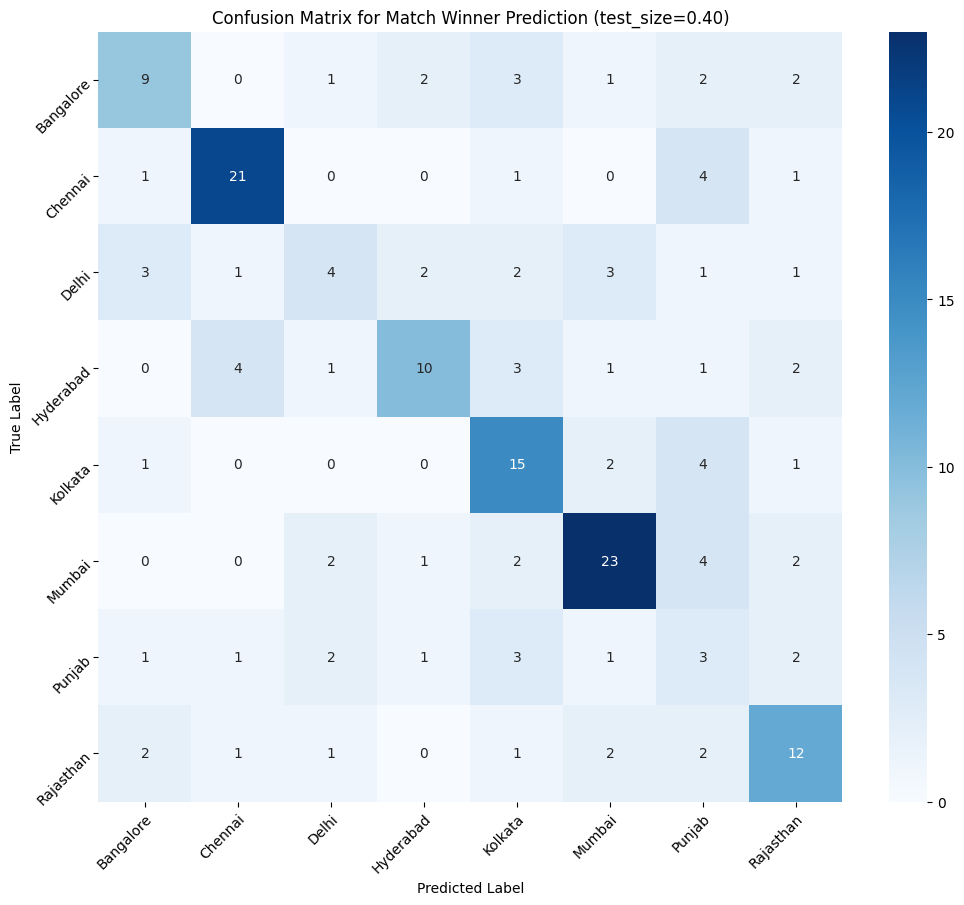

In [151]:

# Extensive Prediction Error Analysis
print("\n--- Prediction Error Analysis ---")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=target_label_encoder.classes_)
# Get class labels in the order they appear in the confusion matrix
class_labels = target_label_encoder.classes_
print("\nConfusion Matrix:")
# Plotting the confusion matrix for better interpretability
plt.figure(figsize=(12, 10))
ax_conf_matrix = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                             xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for Match Winner Prediction (test_size={test_size:.2f})')

# Rotate x and y axis labels
plt.setp(ax_conf_matrix.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax_conf_matrix.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()


--- Feature Importance ---

Feature Importances (Top 15):
team1              0.227107
team2              0.219449
toss_winner        0.125341
venue              0.084346
inning1_runs       0.048417
season             0.047299
city               0.045786
umpire2            0.044720
toss_decision      0.044110
inning1_balls      0.038652
umpire1            0.037406
inning1_wickets    0.037368
dtype: float32


/tmp/ipython-input-152-3106997841.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=features_df.values, y=features_df.index, palette='viridis')


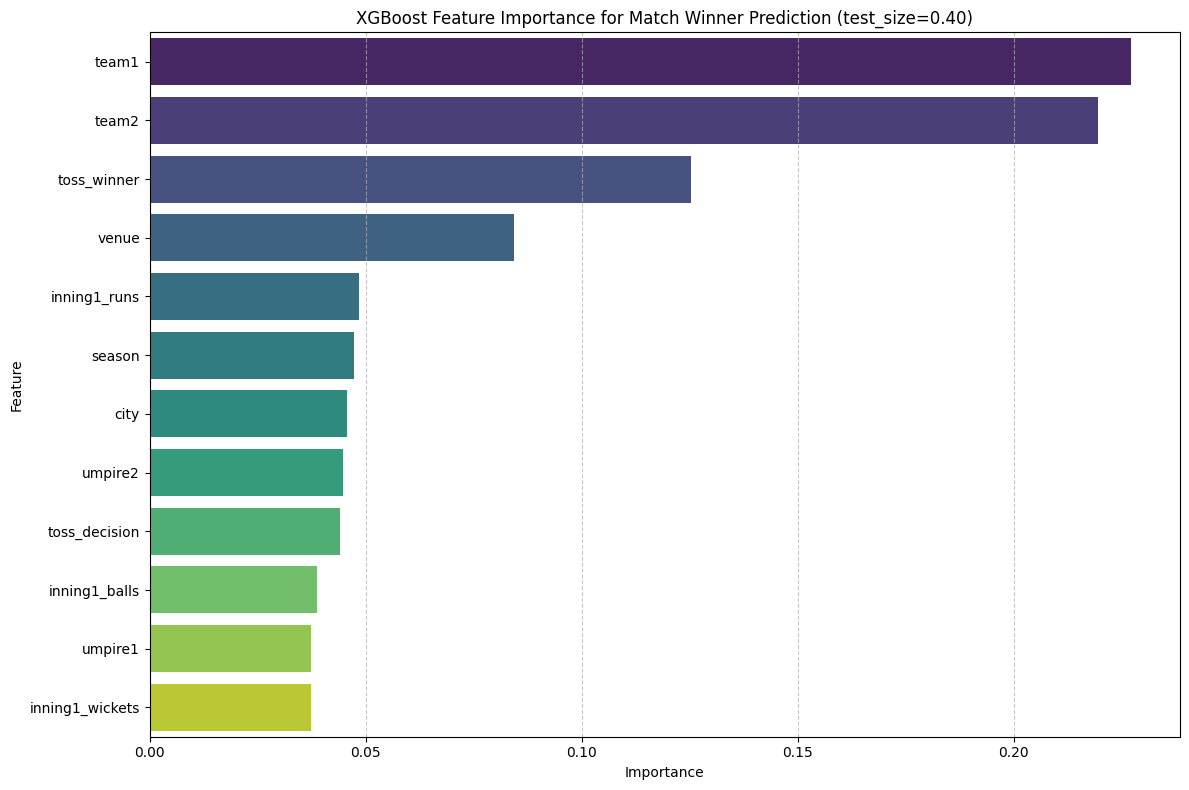

In [152]:

# Feature Importance
print("\n--- Feature Importance ---")
# Get feature importances from the trained model
feature_importances = best_model.feature_importances_

# Create a Series with feature names and their importances
features_df = pd.Series(feature_importances, index=X.columns) # Use X.columns from the full dataset

# Sort the features by importance in descending order
features_df = features_df.sort_values(ascending=False)

print("\nFeature Importances (Top 15):")
print(features_df.head(15))

# Plotting feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=features_df.values, y=features_df.index, palette='viridis')
plt.title(f'XGBoost Feature Importance for Match Winner Prediction (test_size={test_size:.2f})')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [153]:

# Identify misclassified examples (up to 10 for demonstration)
misclassified_indices = np.where(y_test_original != y_pred_original)[0]
print(f"\nTotal misclassified samples: {len(misclassified_indices)}")

if len(misclassified_indices) > 0:
    print("\nSome Misclassified Examples (Actual vs. Predicted):")
    # Take a sample of misclassified indices if there are too many
    sample_misclassified_indices = misclassified_indices[:min(len(misclassified_indices), 10)]

    for i in sample_misclassified_indices:
        actual_winner = y_test_original[i]
        predicted_winner = y_pred_original[i]
        # You might want to print some features of the misclassified sample here
        # E.g., X_test.iloc[i]
        print(f"Sample {i+1}: Actual='{actual_winner}', Predicted='{predicted_winner}'")
else:
    print("\nNo misclassified samples found in the test set. (This is rare with real data)")

print("\n--- End of Error Analysis ---")


Total misclassified samples: 82

Some Misclassified Examples (Actual vs. Predicted):
Sample 1: Actual='Delhi', Predicted='Mumbai'
Sample 3: Actual='Hyderabad', Predicted='Mumbai'
Sample 4: Actual='Mumbai', Predicted='Rajasthan'
Sample 10: Actual='Kolkata', Predicted='Punjab'
Sample 11: Actual='Delhi', Predicted='Bangalore'
Sample 12: Actual='Mumbai', Predicted='Delhi'
Sample 13: Actual='Hyderabad', Predicted='Kolkata'
Sample 14: Actual='Bangalore', Predicted='Rajasthan'
Sample 15: Actual='Delhi', Predicted='Kolkata'
Sample 20: Actual='Delhi', Predicted='Mumbai'

--- End of Error Analysis ---


### SHAP value analysis of the best model

Displaying Global Feature Importance...


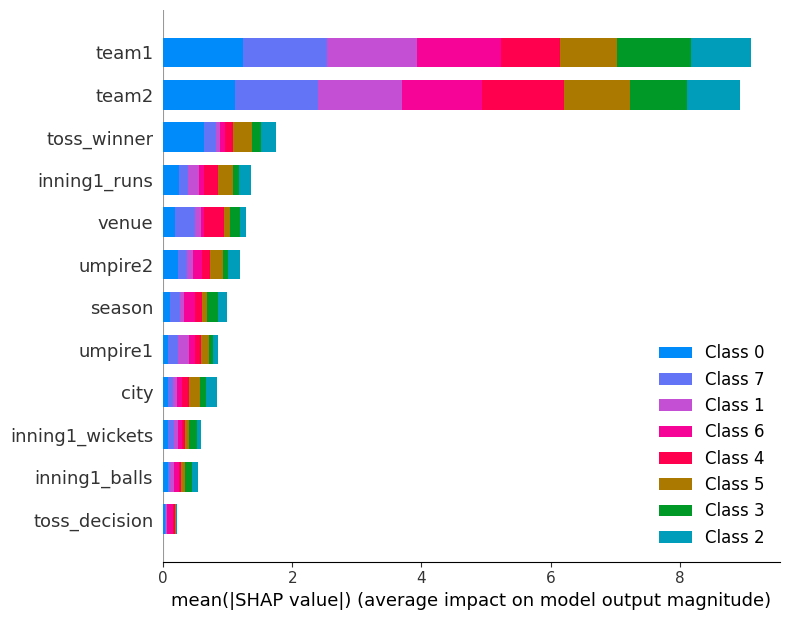


Displaying Detailed Summary Plot (Bee Swarm)...


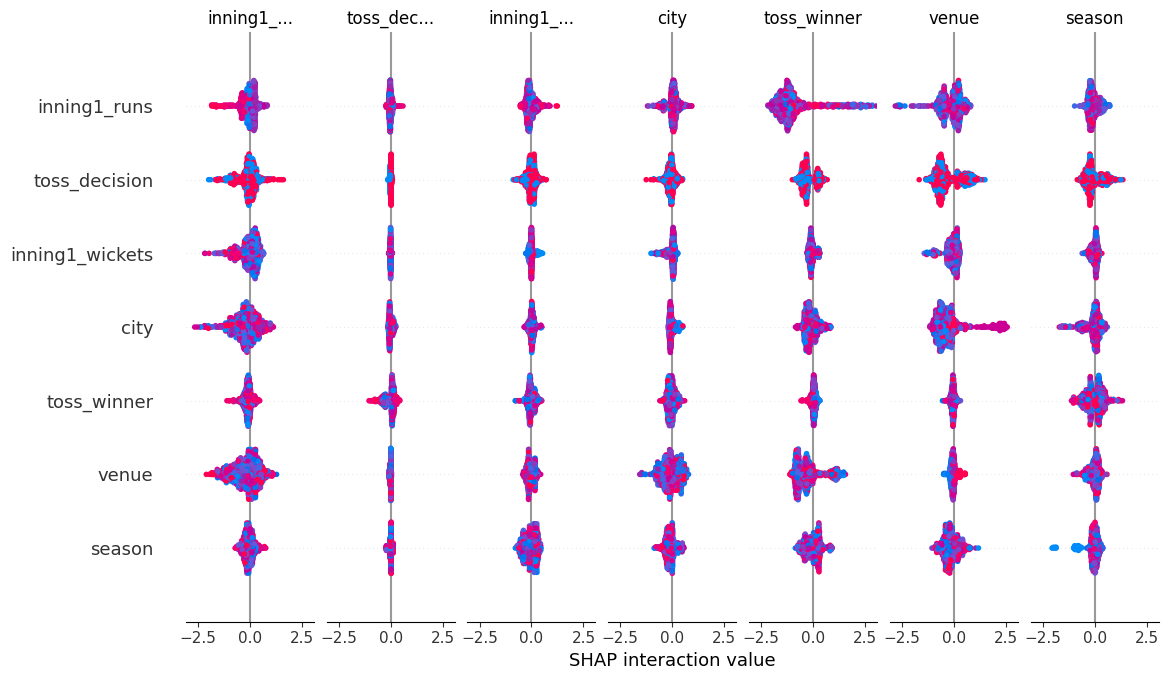


Displaying Force Plot for a single prediction...


In [154]:
# Create a SHAP Explainer
# For tree-based models like XGBoost, TreeExplainer is highly optimized and fast
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for your data (or a subset)
# This can be computationally intensive, so you might start with X_test
shap_values = explainer.shap_values(X)

# --- 4. Generate Insightful Plots ---

# a) Global Feature Importance (Bar Chart)
print("Displaying Global Feature Importance...")
shap.summary_plot(shap_values, X, plot_type="bar")

# b) Detailed Summary Plot (Bee Swarm Plot)
# This is the most popular SHAP plot. It shows not just importance,
# but the impact of each feature's value on the prediction.
print("\nDisplaying Detailed Summary Plot (Bee Swarm)...")
shap.summary_plot(shap_values, X)

# c) Individual Prediction Explanation (Force Plot)
# Explain the prediction for the very first match in your dataset.
print("\nDisplaying Force Plot for a single prediction...")
shap.initjs() # required for force plots in notebooks

Why the Plot Looks the Way It Does
Now that we know the model's real task, the SHAP plot makes perfect sense and is very insightful:

Massive Importance of team1 and team2: The plot shows that team1 and team2 are overwhelmingly the most important features. This is because if the model is trying to predict which of the 8 teams will win, the most helpful information is simply knowing which two teams are playing! The model learns that if 'Mumbai Indians' and 'Chennai Super Kings' are playing, the winner must be one of those two, and not any of the other 6 teams. This is a form of target leakage. The model isn't learning the dynamics of cricket; it's just learning to identify the two participants.

Low Importance of Other Features: Features like inning1_runs, venue, and toss_decision have very low importance in this flawed model. Their subtle influence is completely dwarfed by the massive predictive power of simply knowing the names of the teams involved.

The Solution: Create a True Binary Target
You need to change the fundamental question your model is answering. The goal should not be "Which team won?" but rather "Did team1 win?". This creates a simple Yes/No (1/0) binary problem.

Here is how to fix your pipeline. You must go back to your data preparation stage.

## Currently, we are predicting "Given the match details, which of these 8 teams will be the winner?"
## But what we actually want is a win / loss in a single match
## Using binary classifier for winner column


### if team1 wins, winner row == 1


Shape of features (X): (893, 12)
Shape of target (y): (893,)
------------------------------
Encoded categorical feature: 'city'
Encoded categorical feature: 'venue'
Encoded categorical feature: 'toss_winner'
Encoded categorical feature: 'toss_decision'
Encoded categorical feature: 'umpire1'
Encoded categorical feature: 'umpire2'
Encoded categorical feature: 'team1'
Encoded categorical feature: 'team2'

X (features) after encoding (first 5 rows):
   inning1_runs  inning1_wickets  inning1_balls  season  city  venue  \
0           222                3            124    2008     2     16   
1           240                5            124    2008     7     26   
2           129                8            122    2008    10     11   
3           165                7            123    2008    23     37   
4           110               10            118    2008    21     10   

   toss_winner  toss_decision  umpire1  umpire2  team1  team2  
0            0              1        9       41      

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:12:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tmp/ipython-input-155-1851316130.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Correct Prediction', data=comparison_df, palette=['#F8766D', '#00BFC4'])


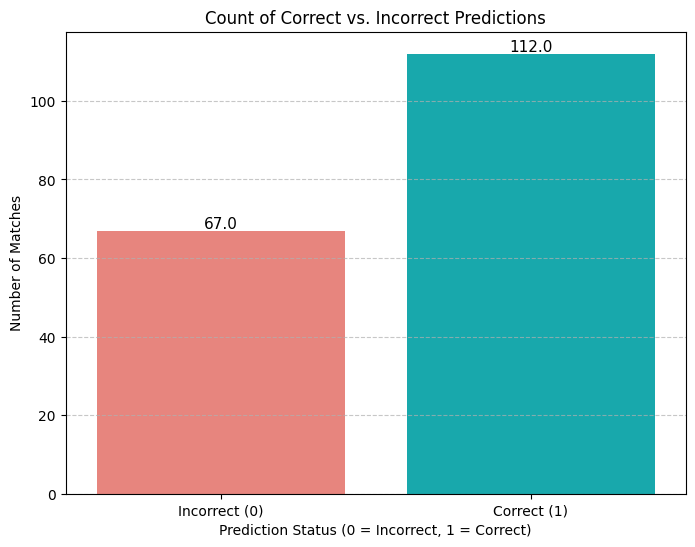

In [155]:
# --- 1. Feature and Target Preparation (Binary Approach) ---

# Separate features (X). Create a copy to avoid SettingWithCopyWarning.
X = df_selected[features].copy()
print(f"Shape of features (X): {X.shape}")

# <<< CHANGE: Create a true binary target variable >>>
# 1 if team1 is the winner, 0 otherwise (meaning team2 won).
# No LabelEncoder is needed for the target anymore.
y = (df_selected['winner'] == df_selected['team1']).astype(int)

print(f"Shape of target (y): {y.shape}")
print("-" * 30)

# Store encoders for feature columns
feature_encoders = {}
# Encode categorical features in X
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    feature_encoders[column] = le
    print(f"Encoded categorical feature: '{column}'")

print("\nX (features) after encoding (first 5 rows):")
print(X.head())
print("\ny (target) as binary (1=team1 won, 0=team2 won):")
print(y.head())
print("-" * 30)


# --- 2. Hyperparameter Tuning with GridSearchCV ---

# param_grid remains the same
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Split the data using the new binary target 'y'
# Renamed variables for clarity (e.g., y_train instead of y_train_encoded)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\n--- Starting Hyperparameter Tuning with GridSearchCV ---")
# Initialize the XGBClassifier
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV to the training data with the binary target
grid_search.fit(X_train, y_train)

print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")
print("-" * 30)


# --- 3. Train and Evaluate the Final Model ---

print("\n--- Evaluating Final Model with Best Parameters ---")
# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# <<< CHANGE: Evaluate directly on binary 0s and 1s >>>
# No need to inverse_transform. 'y_test' and 'y_pred' are already the correct format.
accuracy = accuracy_score(y_test, y_pred)

# <<< CHANGE: Add target_names for a clearer report >>>
report = classification_report(y_test, y_pred, target_names=['team2 Wins (0)', 'team1 Wins (1)'])

print(f"\nAccuracy Score for test_size=0.20: {accuracy:.4f}")
print(f"\nClassification Report for test_size=0.20:\n", report)


# --- 4. Detailed Analysis and Visualization ---

print("\n--- Detailed Analysis of Predictions ---")
# <<< CHANGE: DataFrame uses binary outcomes with clearer column names >>>
comparison_df = pd.DataFrame({
    'Actual Outcome': y_test,
    'Predicted Outcome': y_pred
})
comparison_df['Correct Prediction'] = (comparison_df['Actual Outcome'] == comparison_df['Predicted Outcome']).astype(int)
print(comparison_df)

# Plotting the histogram of correct vs. incorrect predictions
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Correct Prediction', data=comparison_df, palette=['#F8766D', '#00BFC4'])
plt.title('Count of Correct vs. Incorrect Predictions')
plt.xlabel('Prediction Status (0 = Incorrect, 1 = Correct)')
plt.ylabel('Number of Matches')
plt.xticks(ticks=[0, 1], labels=['Incorrect (0)', 'Correct (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

## FINAL ML MODEL


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:12:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Shape of features (X): (893, 9)
Shape of target (y): (893,)
------------------------------
Encoded categorical feature: 'venue'
Encoded categorical feature: 'toss_winner'
Encoded categorical feature: 'toss_decision'
Encoded categorical feature: 'team1'
Encoded categorical feature: 'team2'
------------------------------

Feature encoders saved to 'ipl_feature_encoders.joblib'
------------------------------
Training set size: 714 matches
Test set size: 179 matches
------------------------------

--- Training Final Model with Best Parameters ---
Final model trained successfully.
------------------------------
Model saved to 'ipl_winner_xgb_model.joblib'
------------------------------

--- Evaluating Final Model ---
Final Model Accuracy on Test Set: 0.6089

Final Model Classification Report:
                 precision    recall  f1-score   support

team2 Wins (0)       0.60      0.57      0.59        87
team1 Wins (1)       0.61      0.64      0.63        92

      accuracy                

/tmp/ipython-input-156-1970042522.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Correct_Prediction', data=comparison_df, palette=['#F8766D', '#00BFC4'])


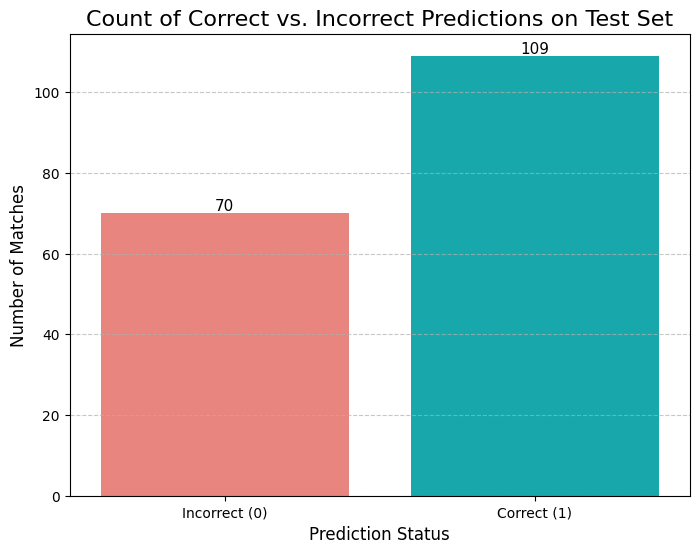

In [156]:
# Assume 'df_selected' is your pre-existing DataFrame with the necessary columns
# and 'features' list is defined. 'target' is still 'winner'.

# --- 1. Feature and Target Preparation (Binary Approach) ---

# <<< UPDATED: Using your specified list of final features >>>
final_features = [
    'inning1_runs', 'inning1_wickets', 'inning1_balls',
    'season', 'venue', 'toss_winner', 'toss_decision',
    'team1', 'team2'
]

# Separate features (X) using the final_features list. Create a copy to avoid SettingWithCopyWarning.
X = df_selected[final_features].copy()
print("Shape of features (X):", X.shape)

# Create a true binary target variable (1 if team1 wins, 0 if team2 wins)
y = (df_selected['winner'] == df_selected['team1']).astype(int)
print("Shape of target (y):", y.shape)
print("-" * 30)

# Encode categorical features in X
feature_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    feature_encoders[column] = le
    print(f"Encoded categorical feature: '{column}'")
print("-" * 30)
# <<< NEW: Save the fitted feature encoders for future use >>>
# This is crucial for processing new data in the exact same way.
encoders_filename = 'ipl_feature_encoders.joblib'
joblib.dump(feature_encoders, encoders_filename)
print(f"\nFeature encoders saved to '{encoders_filename}'")
print("-" * 30)

# --- 2. Data Splitting ---

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape[0]} matches")
print(f"Test set size: {X_test.shape[0]} matches")
print("-" * 30)


# --- 3. Train the Final Model with Best Parameters ---

print("\n--- Training Final Model with Best Parameters ---")

# Define the best parameters you found
final_model = XGBClassifier(
    n_estimators=100,         # The number of boosting rounds or trees to build. More trees can be more powerful but risk overfitting and take longer to train.
    max_depth=4,              # The maximum depth of each tree. Controls model complexity; deeper trees capture more specific patterns but can overfit easily. A depth of 4 is moderately constrained.
    learning_rate=0.2,        # Also called 'eta'. It shrinks the contribution of each tree, preventing drastic changes with each step. A lower value requires more trees but can lead to a more robust model.
    colsample_bytree=0.9,     # The fraction of columns (features) to be randomly sampled for each tree. This helps prevent the model from becoming too reliant on any single feature.
    subsample=1.0,            # The fraction of the training data (rows) to be sampled for each tree. A value of 1.0 means all data is used for every tree. A value < 1.0 helps prevent overfitting.
    eval_metric='logloss',    # The evaluation metric for validation data. 'logloss' is standard for binary classification probability models.
    use_label_encoder=False,  # Set to False to disable the deprecated automatic label encoding and avoid warnings. This assumes you have already encoded your target variable numerically.
    random_state=42           # A seed for the random number generator. This ensures that any process involving randomness (like subsampling) is reproducible every time the code is run.
)

# Train the model on the entire training set
final_model.fit(X_train, y_train)
print("Final model trained successfully.")
print("-" * 30)
# <<< NEW: Save the trained model to a file >>>
model_filename = 'ipl_winner_xgb_model.joblib'
joblib.dump(final_model, model_filename)
print(f"Model saved to '{model_filename}'")
print("-" * 30)

# --- 4. Evaluate the Final Model ---

print("\n--- Evaluating Final Model ---")
# Make predictions on the test set
y_pred = final_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Generate a detailed classification report
report = classification_report(y_test, y_pred, target_names=['team2 Wins (0)', 'team1 Wins (1)'])

print(f"Final Model Accuracy on Test Set: {accuracy:.4f}")
print("\nFinal Model Classification Report:\n", report)


# --- 5. Detailed Analysis and Visualization ---

print("\n--- Detailed Prediction Analysis ---")
# Create a DataFrame for easy comparison of actual vs. predicted outcomes
comparison_df = pd.DataFrame({
    'Actual_Outcome': y_test,
    'Predicted_Outcome': y_pred
})
comparison_df['Correct_Prediction'] = (comparison_df['Actual_Outcome'] == comparison_df['Predicted_Outcome']).astype(int)
print(comparison_df.head(10))

# Plotting the histogram of correct vs. incorrect predictions
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Correct_Prediction', data=comparison_df, palette=['#F8766D', '#00BFC4'])
plt.title('Count of Correct vs. Incorrect Predictions on Test Set', fontsize=16)
plt.xlabel('Prediction Status', fontsize=12)
plt.ylabel('Number of Matches', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Incorrect (0)', 'Correct (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()


--- Generating Confusion Matrix ---


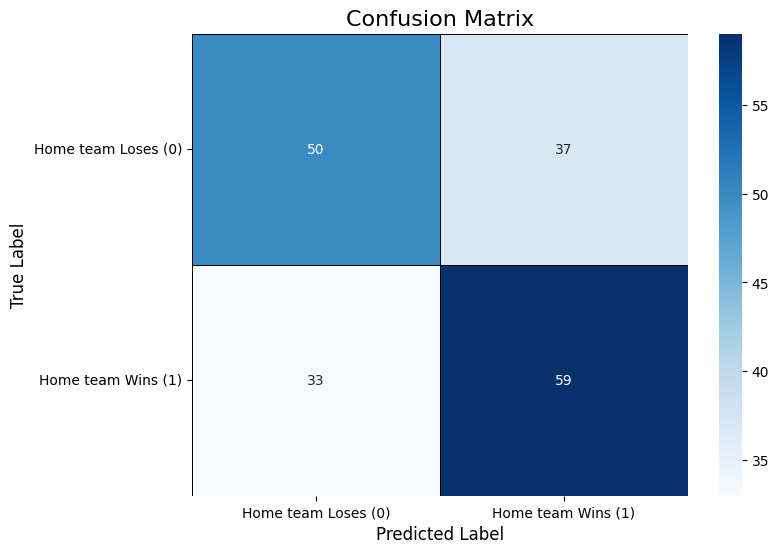


Confusion Matrix Breakdown:
True Negatives (TN - Correctly predicted 'team2 Wins'): 50
False Positives (FP - Incorrectly predicted 'team1 Wins'): 37
False Negatives (FN - Incorrectly predicted 'team2 Wins'): 33
True Positives (TP - Correctly predicted 'team1 Wins'): 59


In [157]:
print("\n--- Generating Confusion Matrix ---")

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define the class names for the labels
class_names = ['Home team Loses (0)', 'Home team Wins (1)']

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            linewidths=.5, linecolor='black')

# Add titles and labels for clarity
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)

# Display the plot
plt.show()

# Optional: Print a breakdown of the confusion matrix values
print("\nConfusion Matrix Breakdown:")
print(f"True Negatives (TN - Correctly predicted 'team2 Wins'): {cm[0][0]}")
print(f"False Positives (FP - Incorrectly predicted 'team1 Wins'): {cm[0][1]}")
print(f"False Negatives (FN - Incorrectly predicted 'team2 Wins'): {cm[1][0]}")
print(f"True Positives (TP - Correctly predicted 'team1 Wins'): {cm[1][1]}")

In [158]:
# Saving the final model file for 2025 current season match prediction

In [159]:
#  Create a Detailed Results DataFrame for Analysis ---

print("\n--- Appending predictions to test set for detailed analysis ---")

# Start with a copy of the test set features to avoid modifying the original
results_df = X_test.copy()

# 1. Add the actual and predicted outcomes (as 0s and 1s)
results_df['Actual_Outcome'] = y_test
results_df['Predicted_Outcome'] = y_pred

# 2. Add human-readable labels for the outcomes
# Map 1 to 'team1 Wins' and 0 to 'team2 Wins'
results_df['Actual_Label'] = results_df['Actual_Outcome'].map({1: 'team1 Wins', 0: 'team2 Wins'})
results_df['Predicted_Label'] = results_df['Predicted_Outcome'].map({1: 'team1 Wins', 0: 'team2 Wins'})

# 3. Add a column to easily see if the prediction was correct
results_df['Prediction_Status'] = 'Correct'
results_df.loc[results_df['Actual_Outcome'] != results_df['Predicted_Outcome'], 'Prediction_Status'] = 'Incorrect'


# 4. Decode the categorical features back to their original string values
# This uses the 'feature_encoders' dictionary we created during the initial encoding.
print("Decoding features back to original labels...")
for column, encoder in feature_encoders.items():
    # Check if the column exists in the DataFrame before trying to decode
    if column in results_df.columns:
        results_df[column] = encoder.inverse_transform(results_df[column])

# 5. Reorder columns for better readability
# Put the most important outcome-related columns first.
desired_order = [
    'Actual_Label',
    'Predicted_Label',
    'Prediction_Status',
    'team1',
    'team2',
    'inning1_runs',
    'venue',
    'toss_winner',
    'toss_decision'
]
# Get the remaining columns from X_test that are not in the desired_order list
remaining_cols = [col for col in X.columns if col not in desired_order]
# Combine the lists to get the final column order
final_order = desired_order + remaining_cols
# Reorder the DataFrame
results_df = results_df[final_order]


print("\n--- Displaying appended DataFrame with actual and predicted results ---")
pd.set_option('display.max_columns', None) # Show all columns
pd.set_option('display.width', 1000) # Set a wider display
print(results_df.head())


# You can now easily filter for incorrect predictions to analyze errors
print("\n--- Example: Analyzing Incorrect Predictions ---")
incorrect_predictions = results_df[results_df['Prediction_Status'] == 'Incorrect']
print(f"Number of incorrect predictions: {len(incorrect_predictions)}")
print("First 5 incorrect predictions:")
print(incorrect_predictions.head())


--- Appending predictions to test set for detailed analysis ---
Decoding features back to original labels...

--- Displaying appended DataFrame with actual and predicted results ---
    Actual_Label Predicted_Label Prediction_Status      team1      team2  inning1_runs                                venue toss_winner toss_decision  inning1_wickets  inning1_balls  season
877   team1 Wins      team2 Wins         Incorrect  Hyderabad  Rajasthan           201   Rajiv Gandhi International Stadium   Hyderabad           bat                3            128    2024
101   team2 Wins      team1 Wins         Incorrect      Delhi     Punjab           120                      OUTsurance Oval      Punjab         field                9            127    2009
819   team2 Wins      team2 Wins           Correct    Kolkata      Delhi           127                 Arun Jaitley Stadium       Delhi         field               10            130    2023
459   team1 Wins      team2 Wins         Incorrect      D

## Trying to predict for 2025 season ipl dataset

### cleaning 2025 season dataset

In [160]:
df_2025 = pd.read_csv('/content/drive/MyDrive/DS_Project_files/matches_2025.csv')


In [161]:
df_2025.columns

Index(['match_id', 'date', 'venue', 'team1', 'team2', 'stage', 'toss_winner', 'toss_decision', 'first_ings_score', 'first_ings_wkts', 'second_ings_score', 'second_ings_wkts', 'match_result', 'match_winner', 'wb_runs', 'wb_wickets', 'balls_left', 'player_of_the_match', 'top_scorer', 'highscore', 'best_bowling', 'best_bowling_figure'], dtype='object')

In [162]:
venue_mapping = {
    'Eden Gardens, Kolkata': 'Eden Gardens, Kolkata',
    'MA Chidambaram Stadium, Chepauk': 'MA Chidambaram Stadium, Chennai',
    'MA Chidambaram Stadium, Chepauk, Chennai': 'MA Chidambaram Stadium, Chennai',
    'Wankhede Stadium, Mumbai': 'Wankhede Stadium, Mumbai',
    'Punjab Cricket Association IS Bindra Stadium, Mohali': 'New PCA Cricket Stadium, Mullanpur',
    'Punjab Cricket Association IS Bindra Stadium': 'New PCA Cricket Stadium, Mullanpur',
    'Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh': 'New PCA Cricket Stadium, Mullanpur',
    'Rajiv Gandhi International Stadium, Uppal': 'Rajiv Gandhi International Stadium, Hyderabad',
    'Rajiv Gandhi International Stadium, Uppal, Hyderabad': 'Rajiv Gandhi International Stadium, Hyderabad',
    'Arun Jaitley Stadium, Delhi': 'Arun Jaitley Stadium, Delhi',
    'Dr DY Patil Sports Academy, Mumbai': 'Dr DY Patil Sports Academy, Mumbai',
    'Maharashtra Cricket Association Stadium, Pune': 'Maharashtra Cricket Association Stadium, Pune',
    'M Chinnaswamy Stadium, Bengaluru': 'M. Chinnaswamy Stadium, Bangalore',
    'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam': 'ACA-VDCA Cricket Stadium, Vishakhapatnam',
    'Sawai Mansingh Stadium, Jaipur': 'Sawai Mansingh Stadium, Jaipur',
    'Himachal Pradesh Cricket Association Stadium, Dharamsala': 'HPCA Stadium, Dharamshala',
    'Brabourne Stadium': 'Brabourne Stadium, Mumbai',
    'Sardar Patel Stadium, Motera': 'Narendra Modi Stadium, Ahmedabad',
    'M. Chinnaswamy Stadium': 'M. Chinnaswamy Stadium, Bangalore',
    'Punjab Cricket Association Stadium, Mohali': 'New PCA Cricket Stadium, Mullanpur'
}

for col in (df_2025.columns):
    df_2025[col] = df_2025[col].apply(lambda x: venue_mapping.get(x, x))

In [163]:
print("--- Data Cleaning for Teams in df_2025 ---")

# --- 1. Define the Team Mapping ---
# Create a dictionary to map team abbreviations to their city/state name.
# 'GT' and 'LSG' are intentionally left out as they will be dropped.
team_mapping = {
    'KKR': 'Kolkata',
    'SRH': 'Hyderabad',
    'CSK': 'Chennai',
    'DC': 'Delhi',
    'RR': 'Rajasthan',
    'MI': 'Mumbai',
    'RCB': 'Bangalore',
    'PBKS': 'Punjab',
    'GT': ' ',
    'LSG': ' '
}

for col in (df_2025.columns):
    df_2025[col] = df_2025[col].apply(lambda x: team_mapping.get(x, x))



--- Data Cleaning for Teams in df_2025 ---


In [164]:
print("--- Preparing Feature DataFrame ---")

# --- Step 1: Define Column Mapping ---
# Create a dictionary to map the existing names to your desired feature names.
column_mapping = {
    'first_ings_score': 'inning1_runs',
    'first_ings_wkts': 'inning1_wickets',
    'match_winner': 'winner'
    # 'venue', 'team1', 'team2', 'toss_winner', 'toss_decision' already match
}

# Apply the renaming
df_2025 = df_2025.rename(columns=column_mapping)
print("Applied column name mapping.")
df_2025['season'] = 2025

print("\n--- Verification of final 'season' column ---")
print("Unique seasons found:", df_2025['season'].unique())
# IMPORTANT: Note on missing columns from your desired list
print("\n--- Notes on Missing Columns ---")
print("The following desired features are NOT in your source DataFrame and cannot be created from it:")
print("- 'city': This needs to be created manually, often by extracting it from the 'venue' string.")
print("- 'inning1_balls': This data is not present.")
print("- 'umpire1', 'umpire2': This data is not present.")
print("They will be excluded from the final feature set.")
print("-" * 30)

df_2025['season'] = 2025
# --- Step 3: Select the Final Set of Features ---

# Define your complete list of desired columns
desired_features = [
    'inning1_runs',
    'inning1_wickets',
    'inning1_balls',
    'season',
    'city',
    'venue',
    'toss_winner',
    'toss_decision',
    'team1',
    'team2',
    'winner'
]

# Filter this list to include only columns that actually exist in our DataFrame now
final_columns_to_keep = [col for col in desired_features if col in df_2025.columns]

print("\nFinal features that will be kept:")
print(final_columns_to_keep)

# Create the final DataFrame with only the selected columns
df_test_2025 = df_2025[final_columns_to_keep].copy()


# --- Verification ---
print("\n--- Final Features DataFrame ---")
print(f"Shape of the final DataFrame: {df_test_2025.shape}")
print("\nFirst 5 rows:")
print(df_test_2025.head())
print("\nDataFrame Info:")
df_test_2025.info()

--- Preparing Feature DataFrame ---
Applied column name mapping.

--- Verification of final 'season' column ---
Unique seasons found: [2025]

--- Notes on Missing Columns ---
The following desired features are NOT in your source DataFrame and cannot be created from it:
- 'city': This needs to be created manually, often by extracting it from the 'venue' string.
- 'inning1_balls': This data is not present.
- 'umpire1', 'umpire2': This data is not present.
They will be excluded from the final feature set.
------------------------------

Final features that will be kept:
['inning1_runs', 'inning1_wickets', 'season', 'venue', 'toss_winner', 'toss_decision', 'team1', 'team2', 'winner']

--- Final Features DataFrame ---
Shape of the final DataFrame: (74, 9)

First 5 rows:
   inning1_runs  inning1_wickets  season                                          venue toss_winner toss_decision      team1      team2     winner
0         174.0              8.0    2025                          Eden Garden

In [165]:
df_test_2025.columns

Index(['inning1_runs', 'inning1_wickets', 'season', 'venue', 'toss_winner', 'toss_decision', 'team1', 'team2', 'winner'], dtype='object')

In [166]:
df_test_2025['inning1_balls'] = 120

In [167]:
df_test_2025 = df_test_2025.dropna(subset=["winner"])

In [168]:
df_test_2025['winner_text'] = df_test_2025['winner']

In [169]:
 df_test_2025['winner'] = (df_test_2025['winner'] == df_test_2025['team1']).astype(int)

In [170]:
df_test_2025.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71 entries, 0 to 73
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   inning1_runs     71 non-null     float64
 1   inning1_wickets  71 non-null     float64
 2   season           71 non-null     int64  
 3   venue            71 non-null     object 
 4   toss_winner      71 non-null     object 
 5   toss_decision    71 non-null     object 
 6   team1            71 non-null     object 
 7   team2            71 non-null     object 
 8   winner           71 non-null     int64  
 9   inning1_balls    71 non-null     int64  
 10  winner_text      71 non-null     object 
dtypes: float64(2), int64(3), object(6)
memory usage: 6.7+ KB


### Predicting for 2025 current data which is completely unseen to model

In [171]:
final_features = [
    'inning1_runs', 'inning1_wickets', 'inning1_balls',
    'season', 'city', 'venue', 'toss_winner', 'toss_decision',
    'team1', 'team2'
]

In [172]:
df = pd.read_csv('aggregated_match_data_by_innings_wo_small_dataset.csv')


In [173]:
df['toss_decision'].unique()

array(['field', 'bat'], dtype=object)

In [174]:
toss_decision_mapping = {
    'Bowl': 'field',
    'Bat': 'bat'
}
df_test_2025['toss_decision'] = df_test_2025['toss_decision'].replace(toss_decision_mapping)

In [175]:
df_test_2025['toss_decision'].unique()

array(['field', 'bat'], dtype=object)

In [176]:
df_test_2025.shape

(71, 11)

In [178]:
df_test_2025['city'] = df_test_2025['venue'].str.split(',').str[1].str.strip()

In [179]:
venue_mapping = {
    'Eden Gardens, Kolkata': 'Eden Gardens',
    'Rajiv Gandhi International Stadium, Hyderabad': 'Rajiv Gandhi International Stadium',
    'MA Chidambaram Stadium, Chennai': 'MA Chidambaram Stadium',
    'Narendra Modi Stadium, Ahmedabad': 'Narendra Modi Stadium, Ahmedabad',
    'Barsapara Stadium, Guwahati': 'Barsapara Cricket Stadium, Guwahati',
    'Wankhede Stadium, Mumbai': 'Wankhede Stadium',
    'M. Chinnaswamy Stadium, Bangalore': 'M Chinnaswamy Stadium', # Standardized to the version without a dot
    'Sawai Mansingh Stadium, Jaipur': 'Sawai Mansingh Stadium',
    'Arun Jaitley Stadium, Delhi': 'Arun Jaitley Stadium' # Mapped to the current name, not the old 'Feroz Shah Kotla'
}

for col in (df_test_2025.columns):
    df_test_2025[col] = df_test_2025[col].apply(lambda x: venue_mapping.get(x, x))

In [180]:
df_test_2025 =  df_test_2025[df_test_2025['toss_winner'] != ' ']

In [185]:

df_test_2025 =  df_test_2025[df_test_2025['team1'] != ' ']
df_test_2025 =  df_test_2025[df_test_2025['team2'] != ' ']

In [181]:
# Create a list of cities to drop
cities_to_drop = ['Vishakhapatnam', 'Lucknow','Mullanpur','Dharamshala']

# Keep only the rows where the city is NOT in the list
df_test_2025 = df_test_2025[~df_test_2025['city'].isin(cities_to_drop)]

In [187]:
import pandas as pd
import joblib

def preprocess_data_for_prediction(df):
    """
    Applies all the necessary preprocessing steps to new, raw data so it
    matches the format the model was trained on.
    """
    print("Preprocessing new data...")

    # a. Rename columns to match training features
    column_mapping = {
        'first_ings_score': 'inning1_runs',
        'first_ings_wkts': 'inning1_wickets',
        'match_winner': 'winner'
        # Add any other remappings you did
    }
    df = df.rename(columns=column_mapping)

    # b. Create 'season' column (setting it to 2025 for this case)
    df['season'] = 2025

    # c. Apply the exact same mappings for venues and teams
    # These dictionaries should be identical to the ones in your training script.
    venue_mapping = {
        'Eden Gardens, Kolkata': 'Eden Gardens, Kolkata',
        'M. Chinnaswamy Stadium': 'M. Chinnaswamy Stadium, Bangalore',
        'Sardar Patel Stadium, Motera': 'Narendra Modi Stadium, Ahmedabad',
        # ... include all other venue mappings ...
    }
    team_mapping = {
        'KKR': 'Kolkata', 'SRH': 'Hyderabad', 'CSK': 'Chennai', 'DC': 'Delhi',
        'RR': 'Rajasthan', 'MI': 'Mumbai', 'RCB': 'Bangalore', 'PBKS': 'Punjab'
    }

    df['venue'] = df['venue'].replace(venue_mapping)
    team_cols = ['team1', 'team2', 'toss_winner']
    for col in team_cols:
        if col in df.columns:
            df[col] = df[col].replace(team_mapping)

    # You might want to add other cleaning steps here if you had more
    # (e.g., handling missing values in inning1_runs)

    print("Preprocessing complete.")
    return df


def make_predictions(input_df, model, encoders, feature_list):
    """
    Takes raw data and returns it with predictions and probabilities.
    """
    # Create a copy to store results without changing the original df
    results_df = input_df.copy()

    # Preprocess the raw data
    processed_df = preprocess_data_for_prediction(input_df)

    # Ensure all required features are present
    # (Handle case where a column might be missing from the new data)
    for feature in feature_list:
        if feature not in processed_df.columns:
            raise ValueError(f"Required feature '{feature}' is missing from the new data.")

    # Select the exact feature set the model was trained on
    X_new = processed_df[feature_list].copy()

    # Encode categorical features using the LOADED encoders
    print("Encoding categorical features...")
    for column, encoder in encoders.items():
        if column in X_new.columns:
            try:
                # Use .transform() ONLY. Never .fit() or .fit_transform() on new data.
                X_new[column] = encoder.transform(X_new[column])
            except ValueError as e:
                print(f"Error transforming column '{column}': {e}")
                print("This means the new data has a category (e.g., a new team or venue) the model has never seen.")
                print("You may need to update your mapping dictionaries or handle this as an unknown category.")
                return None # Stop processing if there's an error

    # Make predictions
    print("Making predictions...")
    predictions = model.predict(X_new)
    probabilities = model.predict_proba(X_new)

    # Add results to the DataFrame
    results_df['predicted_outcome'] = predictions
    results_df['team1_win_probability'] = probabilities[:, 1] # Probability of class '1'

    # Determine the predicted winning team's name
    results_df['predicted_winner'] = results_df.apply(
        lambda row: row['team1'] if row['predicted_outcome'] == 1 else row['team2'],
        axis=1
    )

    return results_df


# --- Main execution block ---
if __name__ == "__main__":
    # 1. Define filenames and the feature list
    MODEL_FILE = 'ipl_winner_xgb_model.joblib'
    ENCODERS_FILE = 'ipl_feature_encoders.joblib'
    NEW_DATA_FILE = df_test_2025

    # This list must be identical to the one used for training
    FINAL_FEATURES = [
        'inning1_runs', 'inning1_wickets', 'inning1_balls',
        'season', 'venue', 'toss_winner', 'toss_decision',
        'team1', 'team2'
    ]

    # 2. Load the trained model and encoders
    try:
        print(f"Loading model from {MODEL_FILE}...")
        loaded_model = joblib.load(MODEL_FILE)
        print(f"Loading encoders from {ENCODERS_FILE}...")
        loaded_encoders = joblib.load(ENCODERS_FILE)
    except FileNotFoundError as e:
        print(f"Error loading files: {e}")
        print("Please ensure the model and encoder files are in the same directory.")
        exit()

    # 3. Load the new data to predict
    try:
        new_matches_df = df_test_2025
    except FileNotFoundError:
        print(f"Error: The new data file '{NEW_DATA_FILE}' was not found.")
        exit()

    # 4. Make predictions
    prediction_results_df = make_predictions(new_matches_df, loaded_model, loaded_encoders, FINAL_FEATURES)

    # 5. Display results
    if prediction_results_df is not None:
        print("\n\n--- PREDICTION RESULTS ---")
        # Define the columns to display for a clean output
        display_columns = ['team1', 'team2', 'venue', 'predicted_winner', 'team1_win_probability']
        print(prediction_results_df[display_columns])

Loading model from ipl_winner_xgb_model.joblib...
Loading encoders from ipl_feature_encoders.joblib...
Preprocessing new data...
Preprocessing complete.
Encoding categorical features...
Making predictions...


--- PREDICTION RESULTS ---
        team1      team2                                venue predicted_winner  team1_win_probability
0     Kolkata  Bangalore                         Eden Gardens        Bangalore               0.294295
1   Hyderabad  Rajasthan   Rajiv Gandhi International Stadium        Hyderabad               0.952462
2     Chennai     Mumbai               MA Chidambaram Stadium          Chennai               0.723375
5   Rajasthan    Kolkata  Barsapara Cricket Stadium, Guwahati          Kolkata               0.059815
7     Chennai  Bangalore               MA Chidambaram Stadium          Chennai               0.985980
10  Rajasthan    Chennai  Barsapara Cricket Stadium, Guwahati          Chennai               0.359497
11     Mumbai    Kolkata                     Wank

In [188]:
prediction_results_df.to_csv("IPL Season 2025 prediction probability.csv")

In [189]:
prediction_results_df.columns

Index(['inning1_runs', 'inning1_wickets', 'season', 'venue', 'toss_winner', 'toss_decision', 'team1', 'team2', 'winner', 'inning1_balls', 'winner_text', 'city', 'predicted_outcome', 'team1_win_probability', 'predicted_winner'], dtype='object')

Visualization #1: Prediction Confidence Distribution (Histogram)
This plot answers the question: "Is my model making confident predictions (close to 100% or 0%), or is it uncertain (close to 50%)?"

A good model should be very confident (probabilities near 0 or 1) when it's correct and less confident when it's wrong. This histogram shows you the distribution of your team1_win_probability.

What to look for:

Ideal Scenario: Two large peaks, one near 0 and one near 1. This means your model is usually very decisive.
Warning Sign: A large peak in the middle (around 0.5). This means your model is often "on the fence" and not very sure about its predictions.

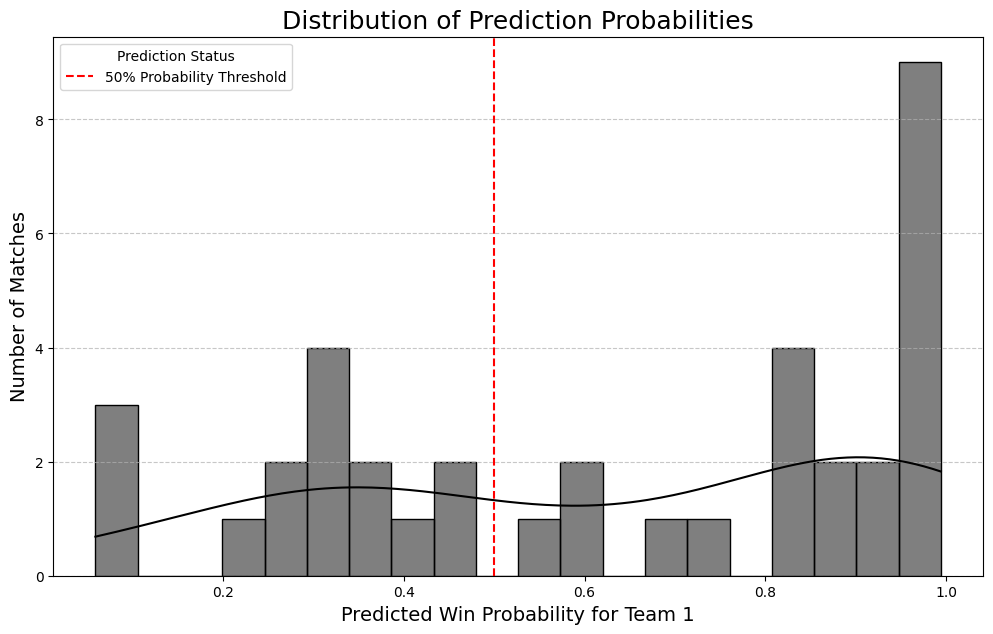

In [191]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume 'prediction_results_df' is the DataFrame with your predictions.
# First, let's create a 'Correct_Prediction' column if you have the true winners.
# If you don't have the true 2025 winners yet, you can run the first part without the 'hue'.

if 'winner' in prediction_results_df.columns:
    # This requires a 'winner' column from the original 2025 data file
    prediction_results_df['Correct_Prediction'] = \
        (prediction_results_df['predicted_winner'] == prediction_results_df['winner'])
else:
    # If true winners aren't known, we can't color by correctness
    prediction_results_df['Correct_Prediction'] = 'Unknown'


# --- Plotting the histogram ---
plt.figure(figsize=(12, 7))
sns.histplot(data=prediction_results_df, x='team1_win_probability', hue='Correct_Prediction',
             kde=True, bins=20, palette={'Correct': '#00BFC4', 'Incorrect': '#F8766D', 'Unknown': 'grey'})

plt.title('Distribution of Prediction Probabilities', fontsize=18)
plt.xlabel('Predicted Win Probability for Team 1', fontsize=14)
plt.ylabel('Number of Matches', fontsize=14)
plt.axvline(0.5, color='red', linestyle='--', label='50% Probability Threshold')
plt.legend(title='Prediction Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Visualization #2: A Clean and Formatted Results Table
This isn't a graph, but it's often the most effective way to showcase results for a general audience. It answers the question: "What are the final predictions in a clear, easy-to-read format?"

We can use pandas styling to make the table more intuitive, for example, by adding color gradients to the probability column.

In [195]:
# Assume 'prediction_results_df' is your DataFrame with predictions

# Select and rename columns for a clean presentation
summary_table = prediction_results_df[[
    'team1',
    'team2',
    'venue',
    'predicted_winner',
    'team1_win_probability'
]].rename(columns={
    'team1': 'Team 1',
    'team2': 'Team 2',
    'venue': 'Venue',
    'predicted_winner': 'Predicted Winner',
    'team1_win_probability': 'Team 1 Win Probability'
})

# Apply styling
# This will color the probability cell based on its value - higher is greener.
styled_table = summary_table.style.background_gradient(
    cmap='RdYlGn',
    subset=['Team 1 Win Probability'],
    low=0.4, high=0.6 # Center the gradient around 50-60%
).format({
    'Team 1 Win Probability': '{:.2%}'.format # Format as a percentage
})

# Display the styled table (this works best in a Jupyter Notebook)
print("\n\n--- Formatted Prediction Summary Table ---")
display(styled_table)

# If not in a notebook, just print the regular DataFrame
# print(summary_table)



--- Formatted Prediction Summary Table ---


,Team 1,Team 2,Venue,Predicted Winner,Team 1 Win Probability
0,Kolkata,Bangalore,Eden Gardens,Bangalore,29.43%
1,Hyderabad,Rajasthan,Rajiv Gandhi International Stadium,Hyderabad,95.25%
2,Chennai,Mumbai,MA Chidambaram Stadium,Chennai,72.34%
5,Rajasthan,Kolkata,"Barsapara Cricket Stadium, Guwahati",Kolkata,5.98%
7,Chennai,Bangalore,MA Chidambaram Stadium,Chennai,98.60%
10,Rajasthan,Chennai,"Barsapara Cricket Stadium, Guwahati",Chennai,35.95%
11,Mumbai,Kolkata,Wankhede Stadium,Kolkata,33.73%
14,Kolkata,Hyderabad,Eden Gardens,Kolkata,97.57%
16,Chennai,Delhi,MA Chidambaram Stadium,Chennai,87.53%
19,Mumbai,Bangalore,Wankhede Stadium,Mumbai,95.81%


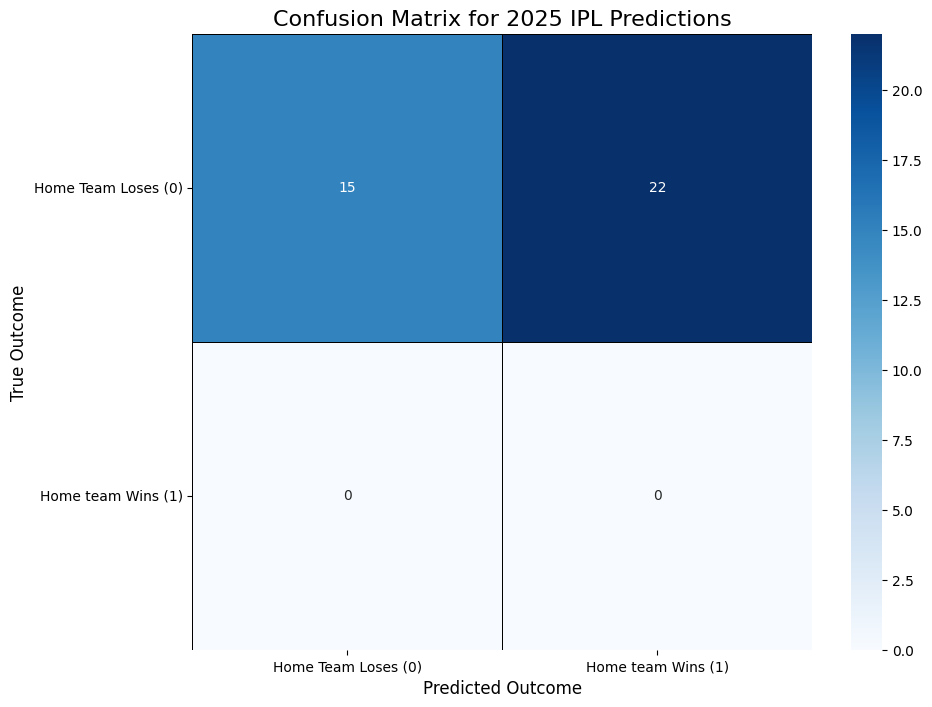

In [198]:
# We create the 'actual_outcome' column to compare with the 'predicted_outcome'.
prediction_results_df['actual_outcome'] = (prediction_results_df['winner'] == prediction_results_df['team1']).astype(int)


# --- Step 2: Calculate the Confusion Matrix ---
# We compare the true outcomes with the predicted outcomes.
cm = confusion_matrix(
    prediction_results_df['actual_outcome'],
    prediction_results_df['predicted_outcome']
)


# --- Step 3: Plot the heatmap ---
plt.figure(figsize=(10, 8))
# Define the labels for the matrix axes
labels = ['Home Team Loses (0)', 'Home team Wins (1)']

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            linewidths=.5, linecolor='black')

# Add titles and labels for clarity
plt.title('Confusion Matrix for 2025 IPL Predictions', fontsize=16)
plt.ylabel('True Outcome', fontsize=12)
plt.xlabel('Predicted Outcome', fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=0)

# Display the plot
plt.show()